In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
import math
from copy import deepcopy
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader,TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.distributions import StudentT

# Define the U-net based score prediction network

# Sampling the Frequency Vector $\mathbf{w}$

Let the total embedding dimension be $D$ (an even integer), and define  
$$
d \;=\; \frac{D}{2}
$$  
as the number of frequency pairs.

The frequency vector  
$$
\mathbf{w} \in \mathbb{R}^{d}
$$  
is sampled once at initialization from a Gaussian with standard deviation given by the `scale` hyperparameter:
$$
w_j \;\sim\; N\bigl(0,\;\text{scale}^2\bigr),
\quad
j = 1,2,\dots,d.
$$
## Time Encoding Function

Let the input timestep be $t \in \mathbb{R}$, the total embedding dimension be $D$ (even), and define  
$$
d = \frac{D}{2}
$$  
as the number of frequency pairs.  Let  
$$
\mathbf{w} = (w_{1}, w_{2}, \dots, w_{d}) \in \mathbb{R}^{d}
$$  
be the fixed frequency vector.

Then the time encoding $\phi: \mathbb{R} \to \mathbb{R}^{D}$ is given by the concatenation of sines and cosines at those frequencies:

$$
\phi(t) =
\begin{pmatrix}
\sin\bigl(2\pi\,w_{1}\,t\bigr)\\
\sin\bigl(2\pi\,w_{2}\,t\bigr)\\
\vdots\\
\sin\bigl(2\pi\,w_{d}\,t\bigr)\\[6pt]
\cos\bigl(2\pi\,w_{1}\,t\bigr)\\
\cos\bigl(2\pi\,w_{2}\,t\bigr)\\
\vdots\\
\cos\bigl(2\pi\,w_{d}\,t\bigr)
\end{pmatrix}
\;\in\;\mathbb{R}^{D}
$$

Equivalently, more compactly:

$$
\phi(t) \;=\;
\bigl[\,
\sin\bigl(2\pi\,t\,\mathbf{w}\bigr),
\;\cos\bigl(2\pi\,t\,\mathbf{w}\bigr)
\,\bigr]
\;\in\;\mathbb{R}^{D/2}\times\mathbb{R}^{D/2} \;=\; \mathbb{R}^{D}.
$$

For a batch of timesteps $\mathbf{t}\in\mathbb{R}^{B}$, you apply $\phi$ element-wise to obtain a $(B\times D)$ tensor.



In [2]:
class TimeEncoding(nn.Module):
    def __init__(self, embed_dim,scale=30):
      super().__init__()
      d =embed_dim//2
      w=torch.randn(d)*scale
      self.register_buffer('W',w,persistent=True)
    def forward(self,t):
      x_proj=t[:,None]*self.W[None,:]*2*math.pi
      return torch.cat([torch.sin(x_proj),torch.cos(x_proj)],dim=-1)

In [3]:
class Dense(nn.Module):
  def __init__(self,input_dim, output_dim):
    super().__init__()
    self.dense=nn.Linear(input_dim,output_dim)
  def forward(self,x):
    return self.dense(x)[...,None,None] #(B,output_dim)->(B, output_dim,1,1)

Assume an input activation tensor  
- $X\in\mathbb{R}^{B\times C\times H\times W}$,  
- with $C$ channels and we choose $G=4$ groups.  
Let each group have $M = C/G$ channels.  

For each sample $b$ and group $g$ (where $g=0,\dots,G-1$), define the set of channel indices  
$S_g = \{\,gM,\,gM+1,\,\dots,\, (g+1)M-1\}$.  

1. **Compute the group mean**  
$$
\mu_{b,g}
= \frac{1}{M\,H\,W}
\sum_{c\in S_g}
\sum_{h=1}^{H}
\sum_{w=1}^{W}
X_{b,c,h,w}
$$

2. **Compute the group variance**  
$$
\sigma^2_{b,g}
= \frac{1}{M\,H\,W}
\sum_{c\in S_g}
\sum_{h=1}^{H}
\sum_{w=1}^{W}
\bigl(X_{b,c,h,w} - \mu_{b,g}\bigr)^{2}
$$

3. **Normalize each element**  
For each channel $c\in S_g$:
$$
\hat X_{b,c,h,w}
= \frac{X_{b,c,h,w} - \mu_{b,g}}
       {\sqrt{\sigma^2_{b,g} + \epsilon}}
$$

4. **Apply learnable affine transform**  
With per‐channel scale $\gamma_c$ and bias $\beta_c$:
$$
Y_{b,c,h,w}
= \gamma_{c}\,\hat X_{b,c,h,w} + \beta_{c}
$$

This implements `nn.GroupNorm(4, num_channels=C)` in PyTorch.  


## U-net for image

In [4]:
class ScoreNet(nn.Module):
  def __init__(self, marginal_prob_std,channels=[32,64,128,256],embed_dim=256):
    super().__init__()
    self.embed=nn.Sequential(TimeEncoding(embed_dim=embed_dim),nn.Linear(embed_dim,embed_dim))
    #u-net encoding
    self.conv1=nn.Conv2d(1,channels[0],3,stride=1,bias=False)
    self.dense1=Dense(embed_dim,channels[0]) #This is for time embedding
    self.gnorm1=nn.GroupNorm(4,num_channels=channels[0])
    self.conv2=nn.Conv2d(channels[0],channels[1],3,stride=2,bias=False)
    self.dense2=Dense(embed_dim,channels[1])
    self.gnorm2=nn.GroupNorm(32,num_channels=channels[1])
    self.conv3=nn.Conv2d(channels[1],channels[2],3,stride=2,bias=False)
    self.dense3=Dense(embed_dim, channels[2])
    self.gnorm3=nn.GroupNorm(32,num_channels=channels[2])
    self.conv4=nn.Conv2d(channels[2],channels[3],3,stride=2,bias=False)
    self.dense4=Dense(embed_dim,channels[3])
    self.gnorm4=nn.GroupNorm(32,num_channels=channels[3])
    #u-net decoding
    self.tconv4=nn.ConvTranspose2d(channels[3],channels[2],3,stride=2,bias=False)
    self.tdense4=Dense(embed_dim,channels[2])
    self.tgnorm4=nn.GroupNorm(32,num_channels=channels[2])
    self.tconv3=nn.ConvTranspose2d(channels[2]+channels[2],channels[1],3,stride=2,bias=False,output_padding=1) #skip connection where we also add the encoder's saved features
    self.tdense3=Dense(embed_dim,channels[1])
    self.tgnorm3=nn.GroupNorm(32,num_channels=channels[1])
    self.tconv2=nn.ConvTranspose2d(channels[1]+channels[1],channels[0],3,stride=2,bias=False,output_padding=1)
    self.tdense2=Dense(embed_dim,channels[0])
    self.tgnorm2=nn.GroupNorm(4,num_channels=channels[0])
    # swish activation function
    self.act=lambda x:x*torch.sigmoid(x)
    self.tconv1=nn.ConvTranspose2d(channels[0]+channels[0],1,3,stride=1)
    self.marginal_prob_std=marginal_prob_std
  def forward(self,x,t):
    #time embedding
    embed=self.act(self.embed(t))
    #encoding
    h1=self.conv1(x)
    h1+=self.dense1(embed)
    h1=self.gnorm1(h1)
    h1=self.act(h1)
    h2=self.conv2(h1)
    h2+=self.dense2(embed)
    h2=self.gnorm2(h2)
    h2=self.act(h2)
    h3=self.conv3(h2)
    h3+=self.dense3(embed)
    h3=self.gnorm3(h3)
    h3=self.act(h3)
    h4=self.conv4(h3)
    h4+=self.dense4(embed)
    h4=self.gnorm4(h4)
    h4=self.act(h4)
    #decoding
    h=self.tconv4(h4)
    h+=self.tdense4(embed)
    h=self.tgnorm4(h)
    h=self.act(h)
    h=self.tconv3(torch.cat([h,h3],dim=1))
    h+=self.tdense3(embed)
    h=self.tgnorm3(h)
    h=self.act(h)
    h=self.tconv2(torch.cat([h,h2],dim=1))
    h+=self.tdense2(embed)
    h=self.tgnorm2(h)
    h=self.act(h)
    h=self.tconv1(torch.cat([h,h1],dim=1))
    # Normalise output
    h=h/self.marginal_prob_std(t)[:,None,None,None]
    return h

# Define the SDE and Denoising Score Matching Objective

SDE is hand-designed, like any other hyper-parameters.

Now let's get our hands dirty on training. First of all, we need to specify an SDE that perturbs the data distribution $p_{0}$ to a prior distribution $p_{T}$. We choose the following SDE:

$$
dx = \sigma^{t}\,dw,\quad t\in[0,1].
$$

In this case,

$$
p_{0t}\bigl(x(t)\mid x(0)\bigr)
= N\Bigl(
x(t)\;;\;x(0),\;\frac{1}{2\log\sigma}\bigl(\sigma^{2t}-1\bigr)\,I
\Bigr).
$$

and we can choose the weighting function

$$
\lambda(t) \;=\;\mathrm{variance}
\;=\;\frac{1}{2\log\sigma}\bigl(\sigma^{2t}-1\bigr).
$$

When $\sigma$ is large, the prior distribution $p_{t=1}$ is

$$
p_{t=1}(x)
=\int p_{0}(y)\,N\Bigl(x ; y,\; \tfrac{1}{2\log\sigma}(\sigma^{2}-1)\,I\Bigr)\,dy
\approx N\Bigl(x ; 0,\; \tfrac{1}{2\log\sigma}(\sigma^{2}-1)\,I\Bigr),
$$

which is approximately independent of the data distribution and is easy to sample from.

Intuitively, this SDE captures a continuum of Gaussian perturbations with variance function $\tfrac{1}{2\log\sigma}(\sigma^{2t}-1)$. This continuum of perturbations allows us to gradually transfer samples from a data distribution $p_{0}$ to a simple Gaussian distribution $p_{1}$.


In [5]:
device='cuda'
def marginal_prob_std(t,sigma):
  t=torch.tensor(t,device=device)
  return torch.sqrt((sigma**(2*t)-1)/2/np.log(sigma))
def diffusion_coeff(t,sigma):
  return torch.tensor(sigma**t,device=device)
sigma=25
marginal_prob_std_fn=functools.partial(marginal_prob_std,sigma=sigma)
diffusion_coeff_fn=functools.partial(diffusion_coeff,sigma=sigma)

The loss is defined as:
$$
\theta^{*} \;=\; \arg\min_{\theta}\; \mathbb{E}_{t}\biggl\{\;\lambda(t)\;\mathbb{E}_{x(0)}\;\mathbb{E}_{x(t)\mid x(0)}\bigl[\bigl\lVert s_{\theta}\bigl(x(t),\,t\bigr)\;-\;\nabla_{x(t)}\log p_{0t}\bigl(x(t)\mid x(0)\bigr)\bigr\rVert_{2}^{2}\bigr]\biggr\}.
$$
where in this speical case:
$$ \nabla_{x(t)}\log p_{0t}\bigl(x(t)\mid x(0)\bigr)=-\frac{\epsilon}{\sigma} $$
$$ \lambda(t)=\sigma^2$$

In [6]:
def loss_fn(score_model,x,marginal_prob_std,eps=1e-5):
  '''
  Args:
    model: Model that represents a time-dependent score-based model
    x: A mini-batch of training data
    marginal_prob_std: A function that gives the standard deviation of the perturbation kernel
  '''
  random_t=torch.rand(x.shape[0],device=x.device)*(1-eps)+eps
  z=torch.randn_like(x)
  std=marginal_prob_std(random_t)  # σ̄(tᵢ) for each tᵢ
  perturbed_x=x+z*std[:,None,None,None] #This is the preturbed x that obtained by adding different noise level.
  score=score_model(perturbed_x,random_t)
  loss=torch.mean(torch.sum((score*std[:,None,None,None]+z)**2,dim=(1,2,3))) #\sigma(S+\epsilon/\sigma)
  return loss

In [7]:
class EMA(nn.Module):
    def __init__(self, model, decay=0.9999, device=None):
        super(EMA, self).__init__()
        # make a copy of the model for accumulating moving average of weights
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay
        self.device = device  # perform EMA on different device from model if set
        if self.device is not None:
            self.module.to(device=self.device)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.state_dict().values(),
                                      model.state_dict().values()):
                if self.device is not None:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(update_fn(ema_v, model_v))

    def update(self, model):
        self._update(
            model,
            update_fn=lambda e, m: self.decay * e + (1.0 - self.decay) * m
        )

    def set(self, model):
        self._update(
            model,
            update_fn=lambda e, m: m
        )

#Training

##Training for image data

In [10]:
score_model=torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn,channels=[32,64,128,256],embed_dim=256)).to(device)
n_epochs=50
batch_size=32
lr=1e-4
dataset=MNIST('.', train=True, transform=transforms.ToTensor(),download=True)
data_loader=DataLoader(dataset,batch_size=batch_size,shuffle=True)
optimizer=torch.optim.Adam(score_model.parameters(),lr=lr)
tqdm_epoch=tqdm(range(n_epochs))
ema=EMA(score_model)
for epoch in tqdm_epoch:
  avg_loss=0
  num_items=0
  for x,y in data_loader:
    x=x.to(device)
    loss=loss_fn(score_model,x,marginal_prob_std=marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ema.update(score_model)
    avg_loss+=loss.item()*x.shape[0]
    num_items+=x.shape[0]
  print('Average scorematching loss: {:5f}'.format(avg_loss/num_items))
  torch.save(score_model.state_dict(),f'ckpt_{epoch}.pth')

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipython-input-5-432520617.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t=torch.tensor(t,device=device)
  2%|▏         | 1/50 [00:26<21:34, 26.41s/it]

Average scorematching loss: 237.705805


  4%|▍         | 2/50 [00:52<21:00, 26.26s/it]

Average scorematching loss: 59.820570


  6%|▌         | 3/50 [01:18<20:29, 26.16s/it]

Average scorematching loss: 41.339774


  8%|▊         | 4/50 [01:44<19:59, 26.08s/it]

Average scorematching loss: 33.553429


 10%|█         | 5/50 [02:10<19:29, 25.98s/it]

Average scorematching loss: 29.344133


 12%|█▏        | 6/50 [02:36<19:08, 26.09s/it]

Average scorematching loss: 26.396197


 14%|█▍        | 7/50 [03:03<18:46, 26.19s/it]

Average scorematching loss: 24.477787


 16%|█▌        | 8/50 [03:29<18:18, 26.16s/it]

Average scorematching loss: 23.334976


 18%|█▊        | 9/50 [03:55<17:48, 26.07s/it]

Average scorematching loss: 22.735967


 20%|██        | 10/50 [04:21<17:23, 26.09s/it]

Average scorematching loss: 21.980605


 22%|██▏       | 11/50 [04:47<16:56, 26.06s/it]

Average scorematching loss: 21.165135


 24%|██▍       | 12/50 [05:13<16:28, 26.02s/it]

Average scorematching loss: 20.780258


 26%|██▌       | 13/50 [05:39<16:09, 26.20s/it]

Average scorematching loss: 20.569305


 28%|██▊       | 14/50 [06:05<15:42, 26.17s/it]

Average scorematching loss: 20.081351


 30%|███       | 15/50 [06:31<15:13, 26.10s/it]

Average scorematching loss: 19.849013


 32%|███▏      | 16/50 [06:57<14:45, 26.06s/it]

Average scorematching loss: 19.617207


 34%|███▍      | 17/50 [07:23<14:18, 26.02s/it]

Average scorematching loss: 19.266301


 36%|███▌      | 18/50 [07:49<13:52, 26.03s/it]

Average scorematching loss: 19.152923


 38%|███▊      | 19/50 [08:16<13:31, 26.17s/it]

Average scorematching loss: 18.929045


 40%|████      | 20/50 [08:41<13:01, 26.05s/it]

Average scorematching loss: 18.795902


 42%|████▏     | 21/50 [09:07<12:33, 25.98s/it]

Average scorematching loss: 18.722645


 44%|████▍     | 22/50 [09:33<12:08, 26.03s/it]

Average scorematching loss: 18.439727


 46%|████▌     | 23/50 [09:59<11:43, 26.04s/it]

Average scorematching loss: 18.311670


 48%|████▊     | 24/50 [10:26<11:17, 26.05s/it]

Average scorematching loss: 18.273622


 50%|█████     | 25/50 [10:52<10:52, 26.12s/it]

Average scorematching loss: 18.184065


 52%|█████▏    | 26/50 [11:18<10:25, 26.08s/it]

Average scorematching loss: 18.180672


 54%|█████▍    | 27/50 [11:44<09:57, 25.98s/it]

Average scorematching loss: 17.920054


 56%|█████▌    | 28/50 [12:09<09:30, 25.91s/it]

Average scorematching loss: 17.867063


 58%|█████▊    | 29/50 [12:35<09:03, 25.89s/it]

Average scorematching loss: 17.618940


 60%|██████    | 30/50 [13:01<08:38, 25.93s/it]

Average scorematching loss: 17.630659


 62%|██████▏   | 31/50 [13:27<08:13, 25.98s/it]

Average scorematching loss: 17.726029


 64%|██████▍   | 32/50 [13:53<07:47, 25.98s/it]

Average scorematching loss: 17.882132


 66%|██████▌   | 33/50 [14:19<07:21, 25.99s/it]

Average scorematching loss: 17.483031


 68%|██████▊   | 34/50 [14:45<06:56, 26.03s/it]

Average scorematching loss: 17.418796


 70%|███████   | 35/50 [15:11<06:29, 25.99s/it]

Average scorematching loss: 17.331559


 72%|███████▏  | 36/50 [15:37<06:04, 26.01s/it]

Average scorematching loss: 17.461378


 74%|███████▍  | 37/50 [16:03<05:38, 26.03s/it]

Average scorematching loss: 17.301317


 76%|███████▌  | 38/50 [16:30<05:12, 26.08s/it]

Average scorematching loss: 17.254561


 78%|███████▊  | 39/50 [16:56<04:46, 26.05s/it]

Average scorematching loss: 17.473961


 80%|████████  | 40/50 [17:21<04:19, 25.99s/it]

Average scorematching loss: 17.217258


 82%|████████▏ | 41/50 [17:47<03:53, 25.93s/it]

Average scorematching loss: 17.116340


 84%|████████▍ | 42/50 [18:13<03:27, 25.93s/it]

Average scorematching loss: 16.799748


 86%|████████▌ | 43/50 [18:39<03:01, 25.93s/it]

Average scorematching loss: 16.844678


 88%|████████▊ | 44/50 [19:05<02:36, 26.04s/it]

Average scorematching loss: 17.011658


 90%|█████████ | 45/50 [19:31<02:09, 25.99s/it]

Average scorematching loss: 17.048888


 92%|█████████▏| 46/50 [19:57<01:43, 25.87s/it]

Average scorematching loss: 16.903647


 94%|█████████▍| 47/50 [20:22<01:17, 25.80s/it]

Average scorematching loss: 16.895029


 96%|█████████▌| 48/50 [20:48<00:51, 25.72s/it]

Average scorematching loss: 16.884458


 98%|█████████▊| 49/50 [21:14<00:25, 25.67s/it]

Average scorematching loss: 16.789050


100%|██████████| 50/50 [21:39<00:00, 26.00s/it]

Average scorematching loss: 16.777491


# Sampling

## Euler Sampling

Recall that for any SDE of the form

$$
dx = f(x, t)\,dt + g(t)\,dw,
$$

the reverse‐time SDE is given by

$$
dx = \bigl[f(x, t) - g(t)^2\,\nabla_x\log p_t(x)\bigr]\,dt + g(t)\,d\bar w.
$$

Since we have chosen the forward SDE to be

$$
dx = \sigma^t\,dw,\quad t\in[0,1],
$$

the reverse‐time SDE is

$$
dx = -\,\sigma^{2t}\,\nabla_x\log p_t(x)\,dt + \sigma^t\,d\bar w.
$$

In particular, using our time‐dependent score‐based model, the reverse‐time SDE can be approximated by

$$
dx = -\,\sigma^{2t}\,s_\theta(x,t)\,dt + \sigma^t\,d\bar w.
$$

To sample from our time‐dependent score‐based model $s_\theta(x,t)$, we first draw a sample from the prior distribution

$$
p_{1} \approx \mathcal{N}\Bigl(x;0,\;\tfrac{1}{2\log\sigma}(\sigma^{2}-1)\,I\Bigr),
$$

and then solve the reverse‐time SDE with numerical methods, such as the Euler–Maruyama approach.  Replacing $dt$ with $\Delta t$ and $dw$ with $z_t\sim\mathcal{N}(0,\,g^2(t)\,\Delta t\,I)$, we obtain the iteration

$$
x_{\,t-\Delta t}
= x_{t}
  + \sigma^{2t}\,s_\theta(x_t,\,t)\,\Delta t
  + \sigma^t\,\sqrt{\Delta t}\;z_t,
\quad
z_t \sim \mathcal{N}(0,\,I).
$$


In [ ]:
num_steps=500
def euler_sampler(score_model,marginal_prob_std,diffusion_coeff,batch_size=64,num_steps=num_steps,device='cuda',eps=1e-3):
  t=torch.ones(batch_size,device=device)
  init_x=torch.randn(batch_size,1,28,28,device=device)*marginal_prob_std(t)[:,None,None,None]
  time_steps=torch.linspace(1,eps,num_steps,device=device)
  step_size=time_steps[0]-time_steps[1]
  x=init_x
  with torch.no_grad():
    for time_step in tqdm.tqdm(time_steps):
      batch_time_step=torch.ones(batch_size,device=device)*time_step
      g=diffusion_coeff(batch_time_step)
      mean_x=x+(g**2)[:,None,None,None]*score_model(x,batch_time_step)*step_size
      z=torch.randn_like(x)
      x=mean_x+torch.sqrt(step_size)*g[:,None,None,None]*z
  return mean_x


## PC sampler

corrector:
$$ x_t ← x_t+α s_θ(x_t,t)+\sqrt{2α} z$$
predictor:
$$x_{t-Δt}=\mu+g_t \sqrt{Δt} z$$
where $\mu=x_t+g_t^2s_\theta (x_t,t)Δt$


In [16]:
signal_to_noise_ratio = 0.16
num_steps = 500

def pc_sampler(
    score_model,
    marginal_prob_std,
    diffusion_coeff,
    batch_size=64,
    num_steps=num_steps,
    snr=signal_to_noise_ratio,
    device='cuda',
    eps=1e-3
):
    """Generate samples from score-based models with Predictor-Corrector method.

    Args:
        score_model: A PyTorch model that represents the time-dependent score-based model.
        marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
        diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
        batch_size: The number of samplers to generate by calling this function once.
        num_steps: The number of sampling steps. Equivalent to the number of discretized time steps.
        snr: Signal-to-noise ratio for the corrector updates.
        device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
        eps: The smallest time step for numerical stability.

    Returns:
        Samples.
    """

    # 1) Initialize from the prior at t=1
    t = torch.ones(batch_size, device=device)
    init_noise = torch.randn_like(score_model.module.conv1.weight[:, :1, :1].unsqueeze(0))  # dummy to get (1,1,H,W)
    # Actually just sample standard normal image noise:
    with torch.no_grad():
        x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]

    # 2) Set up the time grid
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size  = time_steps[0] - time_steps[1]

    # 3) Loop over reverse time
    with torch.no_grad():
        for time_step in tqdm(time_steps, desc='PC sampling'):
            # expand to per-sample
            batch_t = torch.full((batch_size,), time_step, device=device)
            # ---- Predictor: Euler–Maruyama ----
            g = diffusion_coeff(batch_t)                              # g(t)
            score = score_model(x, batch_t)
            # mean update
            x_mean = x + (g**2)[:, None, None, None] * score * step_size
            # stochastic update
            x = x_mean + torch.sqrt((g**2) * step_size)[:, None, None, None] * torch.randn_like(x)


            # ---- Corrector: Langevin MCMC ----
            grad = score_model(x, batch_t)                           # ∇x log p_t(x)
            # compute norms per-sample
            grad_norm  = torch.norm(grad.reshape(batch_size, -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:])) #\sqrt{C\,H\,W}
            # step size for Langevin
            langevin_step = (snr * noise_norm / grad_norm) ** 2 * 2
            print(f'{langevin_step=}')
            # one Langevin update
            for _ in range(10):
                x = x + langevin_step * grad + torch.sqrt(2 * langevin_step) * torch.randn_like(x)
                grad=score_model(x,batch_t)
                grad_norm=torch.norm(grad.reshape(batch_size,-1),dim=-1).mean()
                noise_norm=np.sqrt(np.prod(x.shape[1:]))
                langevin_step=(snr*noise_norm/grad_norm)**2*2
                print(f'{langevin_step=}')


    # 4) Return the final denoised mean
    return x_mean

/tmp/ipython-input-5-432520617.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t=torch.tensor(t,device=device)


Generating samples using PC sampler...


PC sampling:   0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipython-input-5-432520617.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t,device=device)
PC sampling:   1%|          | 3/500 [00:00<00:21, 23.35it/s]

langevin_step=tensor(4.8457, device='cuda:0')
langevin_step=tensor(4.8255, device='cuda:0')
langevin_step=tensor(4.8419, device='cuda:0')
langevin_step=tensor(4.8312, device='cuda:0')
langevin_step=tensor(4.8561, device='cuda:0')
langevin_step=tensor(4.8864, device='cuda:0')
langevin_step=tensor(4.9139, device='cuda:0')
langevin_step=tensor(4.9030, device='cuda:0')
langevin_step=tensor(4.8587, device='cuda:0')
langevin_step=tensor(4.8240, device='cuda:0')
langevin_step=tensor(4.8014, device='cuda:0')
langevin_step=tensor(4.9020, device='cuda:0')
langevin_step=tensor(4.9234, device='cuda:0')
langevin_step=tensor(4.9270, device='cuda:0')
langevin_step=tensor(4.8766, device='cuda:0')
langevin_step=tensor(4.8619, device='cuda:0')
langevin_step=tensor(4.8936, device='cuda:0')
langevin_step=tensor(4.8565, device='cuda:0')
langevin_step=tensor(4.8313, device='cuda:0')
langevin_step=tensor(4.8230, device='cuda:0')
langevin_step=tensor(4.8610, device='cuda:0')
langevin_step=tensor(4.8455, devic

PC sampling:   2%|▏         | 9/500 [00:00<00:20, 23.53it/s]

langevin_step=tensor(4.6628, device='cuda:0')
langevin_step=tensor(4.6170, device='cuda:0')
langevin_step=tensor(4.5398, device='cuda:0')
langevin_step=tensor(4.5332, device='cuda:0')
langevin_step=tensor(4.5306, device='cuda:0')
langevin_step=tensor(4.6036, device='cuda:0')
langevin_step=tensor(4.5986, device='cuda:0')
langevin_step=tensor(4.5855, device='cuda:0')
langevin_step=tensor(4.5866, device='cuda:0')
langevin_step=tensor(4.5821, device='cuda:0')
langevin_step=tensor(4.5825, device='cuda:0')
langevin_step=tensor(4.5921, device='cuda:0')
langevin_step=tensor(4.5916, device='cuda:0')
langevin_step=tensor(4.5250, device='cuda:0')
langevin_step=tensor(4.4908, device='cuda:0')
langevin_step=tensor(4.4664, device='cuda:0')
langevin_step=tensor(4.4687, device='cuda:0')
langevin_step=tensor(4.4910, device='cuda:0')
langevin_step=tensor(4.4877, device='cuda:0')
langevin_step=tensor(4.4738, device='cuda:0')
langevin_step=tensor(4.4650, device='cuda:0')
langevin_step=tensor(4.4390, devic

PC sampling:   2%|▏         | 12/500 [00:00<00:20, 23.41it/s]

langevin_step=tensor(4.3534, device='cuda:0')
langevin_step=tensor(4.3363, device='cuda:0')
langevin_step=tensor(4.3435, device='cuda:0')
langevin_step=tensor(4.3585, device='cuda:0')
langevin_step=tensor(4.3885, device='cuda:0')
langevin_step=tensor(4.3809, device='cuda:0')
langevin_step=tensor(4.3230, device='cuda:0')
langevin_step=tensor(4.3268, device='cuda:0')
langevin_step=tensor(4.3520, device='cuda:0')
langevin_step=tensor(4.3683, device='cuda:0')
langevin_step=tensor(4.3568, device='cuda:0')
langevin_step=tensor(4.3292, device='cuda:0')
langevin_step=tensor(4.3278, device='cuda:0')
langevin_step=tensor(4.3140, device='cuda:0')
langevin_step=tensor(4.3532, device='cuda:0')
langevin_step=tensor(4.3280, device='cuda:0')
langevin_step=tensor(4.3314, device='cuda:0')
langevin_step=tensor(4.2831, device='cuda:0')
langevin_step=tensor(4.2900, device='cuda:0')
langevin_step=tensor(4.2485, device='cuda:0')
langevin_step=tensor(4.2056, device='cuda:0')
langevin_step=tensor(4.2435, devic

PC sampling:   4%|▎         | 18/500 [00:00<00:20, 23.38it/s]

langevin_step=tensor(3.9816, device='cuda:0')
langevin_step=tensor(3.9936, device='cuda:0')
langevin_step=tensor(4.0192, device='cuda:0')
langevin_step=tensor(4.0125, device='cuda:0')
langevin_step=tensor(4.0284, device='cuda:0')
langevin_step=tensor(4.0287, device='cuda:0')
langevin_step=tensor(4.0264, device='cuda:0')
langevin_step=tensor(4.0452, device='cuda:0')
langevin_step=tensor(3.9828, device='cuda:0')
langevin_step=tensor(3.9951, device='cuda:0')
langevin_step=tensor(4.0034, device='cuda:0')
langevin_step=tensor(4.0438, device='cuda:0')
langevin_step=tensor(4.0134, device='cuda:0')
langevin_step=tensor(3.9883, device='cuda:0')
langevin_step=tensor(4.0218, device='cuda:0')
langevin_step=tensor(3.9869, device='cuda:0')
langevin_step=tensor(3.9651, device='cuda:0')
langevin_step=tensor(3.9827, device='cuda:0')
langevin_step=tensor(4.0082, device='cuda:0')
langevin_step=tensor(3.9606, device='cuda:0')
langevin_step=tensor(3.9605, device='cuda:0')
langevin_step=tensor(3.9545, devic

PC sampling:   4%|▍         | 21/500 [00:00<00:20, 23.47it/s]

langevin_step=tensor(3.8291, device='cuda:0')
langevin_step=tensor(3.8327, device='cuda:0')
langevin_step=tensor(3.8034, device='cuda:0')
langevin_step=tensor(3.8204, device='cuda:0')
langevin_step=tensor(3.8266, device='cuda:0')
langevin_step=tensor(3.8355, device='cuda:0')
langevin_step=tensor(3.8419, device='cuda:0')
langevin_step=tensor(3.8411, device='cuda:0')
langevin_step=tensor(3.8334, device='cuda:0')
langevin_step=tensor(3.8321, device='cuda:0')
langevin_step=tensor(3.8271, device='cuda:0')
langevin_step=tensor(3.7985, device='cuda:0')
langevin_step=tensor(3.7642, device='cuda:0')
langevin_step=tensor(3.7465, device='cuda:0')
langevin_step=tensor(3.7627, device='cuda:0')
langevin_step=tensor(3.7397, device='cuda:0')
langevin_step=tensor(3.7371, device='cuda:0')
langevin_step=tensor(3.7636, device='cuda:0')
langevin_step=tensor(3.7882, device='cuda:0')
langevin_step=tensor(3.7973, device='cuda:0')
langevin_step=tensor(3.7599, device='cuda:0')
langevin_step=tensor(3.7327, devic

PC sampling:   5%|▌         | 27/500 [00:01<00:20, 23.46it/s]

langevin_step=tensor(3.5886, device='cuda:0')
langevin_step=tensor(3.5798, device='cuda:0')
langevin_step=tensor(3.5573, device='cuda:0')
langevin_step=tensor(3.5027, device='cuda:0')
langevin_step=tensor(3.4896, device='cuda:0')
langevin_step=tensor(3.4705, device='cuda:0')
langevin_step=tensor(3.4708, device='cuda:0')
langevin_step=tensor(3.4933, device='cuda:0')
langevin_step=tensor(3.4863, device='cuda:0')
langevin_step=tensor(3.4790, device='cuda:0')
langevin_step=tensor(3.4995, device='cuda:0')
langevin_step=tensor(3.5144, device='cuda:0')
langevin_step=tensor(3.5111, device='cuda:0')
langevin_step=tensor(3.5578, device='cuda:0')
langevin_step=tensor(3.5229, device='cuda:0')
langevin_step=tensor(3.5357, device='cuda:0')
langevin_step=tensor(3.5290, device='cuda:0')
langevin_step=tensor(3.5610, device='cuda:0')
langevin_step=tensor(3.5865, device='cuda:0')
langevin_step=tensor(3.5905, device='cuda:0')
langevin_step=tensor(3.6097, device='cuda:0')
langevin_step=tensor(3.6000, devic

PC sampling:   7%|▋         | 33/500 [00:01<00:19, 23.51it/s]

langevin_step=tensor(3.4252, device='cuda:0')
langevin_step=tensor(3.4462, device='cuda:0')
langevin_step=tensor(3.4257, device='cuda:0')
langevin_step=tensor(3.4405, device='cuda:0')
langevin_step=tensor(3.4030, device='cuda:0')
langevin_step=tensor(3.4194, device='cuda:0')
langevin_step=tensor(3.4176, device='cuda:0')
langevin_step=tensor(3.4078, device='cuda:0')
langevin_step=tensor(3.4010, device='cuda:0')
langevin_step=tensor(3.4198, device='cuda:0')
langevin_step=tensor(3.4150, device='cuda:0')
langevin_step=tensor(3.4234, device='cuda:0')
langevin_step=tensor(3.4120, device='cuda:0')
langevin_step=tensor(3.4164, device='cuda:0')
langevin_step=tensor(3.3875, device='cuda:0')
langevin_step=tensor(3.3363, device='cuda:0')
langevin_step=tensor(3.3598, device='cuda:0')
langevin_step=tensor(3.3546, device='cuda:0')
langevin_step=tensor(3.3753, device='cuda:0')
langevin_step=tensor(3.3629, device='cuda:0')
langevin_step=tensor(3.3555, device='cuda:0')
langevin_step=tensor(3.3563, devic

PC sampling:   7%|▋         | 36/500 [00:01<00:19, 23.37it/s]

langevin_step=tensor(3.1907, device='cuda:0')
langevin_step=tensor(3.1705, device='cuda:0')
langevin_step=tensor(3.1582, device='cuda:0')
langevin_step=tensor(3.1678, device='cuda:0')
langevin_step=tensor(3.1570, device='cuda:0')
langevin_step=tensor(3.1503, device='cuda:0')
langevin_step=tensor(3.1074, device='cuda:0')
langevin_step=tensor(3.1075, device='cuda:0')
langevin_step=tensor(3.1154, device='cuda:0')
langevin_step=tensor(3.1242, device='cuda:0')
langevin_step=tensor(3.1068, device='cuda:0')
langevin_step=tensor(3.1109, device='cuda:0')
langevin_step=tensor(3.1243, device='cuda:0')
langevin_step=tensor(3.1119, device='cuda:0')
langevin_step=tensor(3.1118, device='cuda:0')
langevin_step=tensor(3.1121, device='cuda:0')
langevin_step=tensor(3.1390, device='cuda:0')
langevin_step=tensor(3.1063, device='cuda:0')
langevin_step=tensor(3.1222, device='cuda:0')
langevin_step=tensor(3.1104, device='cuda:0')
langevin_step=tensor(3.0863, device='cuda:0')
langevin_step=tensor(3.0649, devic

PC sampling:   8%|▊         | 42/500 [00:01<00:19, 22.96it/s]

langevin_step=tensor(3.0145, device='cuda:0')
langevin_step=tensor(2.9761, device='cuda:0')
langevin_step=tensor(2.9916, device='cuda:0')
langevin_step=tensor(3.0088, device='cuda:0')
langevin_step=tensor(2.9948, device='cuda:0')
langevin_step=tensor(3.0034, device='cuda:0')
langevin_step=tensor(3.0112, device='cuda:0')
langevin_step=tensor(3.0024, device='cuda:0')
langevin_step=tensor(3.0046, device='cuda:0')
langevin_step=tensor(2.9644, device='cuda:0')
langevin_step=tensor(2.9711, device='cuda:0')
langevin_step=tensor(2.9929, device='cuda:0')
langevin_step=tensor(2.9846, device='cuda:0')
langevin_step=tensor(2.9732, device='cuda:0')
langevin_step=tensor(2.9638, device='cuda:0')
langevin_step=tensor(2.9892, device='cuda:0')
langevin_step=tensor(2.9618, device='cuda:0')
langevin_step=tensor(2.9863, device='cuda:0')
langevin_step=tensor(2.9724, device='cuda:0')
langevin_step=tensor(2.9731, device='cuda:0')
langevin_step=tensor(2.9322, device='cuda:0')
langevin_step=tensor(2.9359, devic

PC sampling:   9%|▉         | 45/500 [00:01<00:19, 23.00it/s]

langevin_step=tensor(2.8399, device='cuda:0')
langevin_step=tensor(2.8623, device='cuda:0')
langevin_step=tensor(2.8433, device='cuda:0')
langevin_step=tensor(2.8665, device='cuda:0')
langevin_step=tensor(2.8254, device='cuda:0')
langevin_step=tensor(2.8242, device='cuda:0')
langevin_step=tensor(2.8409, device='cuda:0')
langevin_step=tensor(2.8264, device='cuda:0')
langevin_step=tensor(2.8449, device='cuda:0')
langevin_step=tensor(2.8258, device='cuda:0')
langevin_step=tensor(2.8108, device='cuda:0')
langevin_step=tensor(2.7983, device='cuda:0')
langevin_step=tensor(2.7873, device='cuda:0')
langevin_step=tensor(2.7865, device='cuda:0')
langevin_step=tensor(2.7907, device='cuda:0')
langevin_step=tensor(2.7544, device='cuda:0')
langevin_step=tensor(2.7668, device='cuda:0')
langevin_step=tensor(2.7841, device='cuda:0')
langevin_step=tensor(2.7659, device='cuda:0')
langevin_step=tensor(2.7615, device='cuda:0')
langevin_step=tensor(2.7384, device='cuda:0')
langevin_step=tensor(2.7459, devic

PC sampling:  10%|█         | 51/500 [00:02<00:19, 22.71it/s]

langevin_step=tensor(2.6326, device='cuda:0')
langevin_step=tensor(2.6295, device='cuda:0')
langevin_step=tensor(2.6107, device='cuda:0')
langevin_step=tensor(2.6004, device='cuda:0')
langevin_step=tensor(2.6055, device='cuda:0')
langevin_step=tensor(2.6154, device='cuda:0')
langevin_step=tensor(2.6112, device='cuda:0')
langevin_step=tensor(2.6416, device='cuda:0')
langevin_step=tensor(2.6523, device='cuda:0')
langevin_step=tensor(2.6110, device='cuda:0')
langevin_step=tensor(2.6334, device='cuda:0')
langevin_step=tensor(2.6268, device='cuda:0')
langevin_step=tensor(2.6176, device='cuda:0')
langevin_step=tensor(2.6189, device='cuda:0')
langevin_step=tensor(2.6236, device='cuda:0')
langevin_step=tensor(2.6237, device='cuda:0')
langevin_step=tensor(2.6206, device='cuda:0')
langevin_step=tensor(2.6250, device='cuda:0')
langevin_step=tensor(2.6143, device='cuda:0')
langevin_step=tensor(2.6011, device='cuda:0')
langevin_step=tensor(2.5675, device='cuda:0')
langevin_step=tensor(2.5823, devic

PC sampling:  11%|█         | 54/500 [00:02<00:19, 22.89it/s]

langevin_step=tensor(2.5128, device='cuda:0')
langevin_step=tensor(2.4824, device='cuda:0')
langevin_step=tensor(2.4656, device='cuda:0')
langevin_step=tensor(2.4870, device='cuda:0')
langevin_step=tensor(2.4805, device='cuda:0')
langevin_step=tensor(2.4699, device='cuda:0')
langevin_step=tensor(2.4862, device='cuda:0')
langevin_step=tensor(2.4702, device='cuda:0')
langevin_step=tensor(2.4692, device='cuda:0')
langevin_step=tensor(2.4418, device='cuda:0')
langevin_step=tensor(2.4270, device='cuda:0')
langevin_step=tensor(2.4203, device='cuda:0')
langevin_step=tensor(2.3938, device='cuda:0')
langevin_step=tensor(2.3943, device='cuda:0')
langevin_step=tensor(2.3840, device='cuda:0')
langevin_step=tensor(2.4083, device='cuda:0')
langevin_step=tensor(2.4179, device='cuda:0')
langevin_step=tensor(2.4354, device='cuda:0')
langevin_step=tensor(2.4380, device='cuda:0')
langevin_step=tensor(2.4316, device='cuda:0')
langevin_step=tensor(2.4198, device='cuda:0')
langevin_step=tensor(2.4103, devic

PC sampling:  12%|█▏        | 60/500 [00:02<00:18, 23.40it/s]

langevin_step=tensor(2.3329, device='cuda:0')
langevin_step=tensor(2.3529, device='cuda:0')
langevin_step=tensor(2.3498, device='cuda:0')
langevin_step=tensor(2.3282, device='cuda:0')
langevin_step=tensor(2.3102, device='cuda:0')
langevin_step=tensor(2.3219, device='cuda:0')
langevin_step=tensor(2.3256, device='cuda:0')
langevin_step=tensor(2.3290, device='cuda:0')
langevin_step=tensor(2.3201, device='cuda:0')
langevin_step=tensor(2.3270, device='cuda:0')
langevin_step=tensor(2.3449, device='cuda:0')
langevin_step=tensor(2.3502, device='cuda:0')
langevin_step=tensor(2.3599, device='cuda:0')
langevin_step=tensor(2.3533, device='cuda:0')
langevin_step=tensor(2.3263, device='cuda:0')
langevin_step=tensor(2.3142, device='cuda:0')
langevin_step=tensor(2.3060, device='cuda:0')
langevin_step=tensor(2.3033, device='cuda:0')
langevin_step=tensor(2.2862, device='cuda:0')
langevin_step=tensor(2.2905, device='cuda:0')
langevin_step=tensor(2.3016, device='cuda:0')
langevin_step=tensor(2.2929, devic

PC sampling:  13%|█▎        | 66/500 [00:02<00:18, 23.34it/s]

langevin_step=tensor(2.1896, device='cuda:0')
langevin_step=tensor(2.1874, device='cuda:0')
langevin_step=tensor(2.1889, device='cuda:0')
langevin_step=tensor(2.2030, device='cuda:0')
langevin_step=tensor(2.1998, device='cuda:0')
langevin_step=tensor(2.1958, device='cuda:0')
langevin_step=tensor(2.1821, device='cuda:0')
langevin_step=tensor(2.1935, device='cuda:0')
langevin_step=tensor(2.1919, device='cuda:0')
langevin_step=tensor(2.1907, device='cuda:0')
langevin_step=tensor(2.1961, device='cuda:0')
langevin_step=tensor(2.1763, device='cuda:0')
langevin_step=tensor(2.1929, device='cuda:0')
langevin_step=tensor(2.1711, device='cuda:0')
langevin_step=tensor(2.2018, device='cuda:0')
langevin_step=tensor(2.1961, device='cuda:0')
langevin_step=tensor(2.1948, device='cuda:0')
langevin_step=tensor(2.1749, device='cuda:0')
langevin_step=tensor(2.1899, device='cuda:0')
langevin_step=tensor(2.1787, device='cuda:0')
langevin_step=tensor(2.1765, device='cuda:0')
langevin_step=tensor(2.1754, devic

PC sampling:  14%|█▍        | 69/500 [00:02<00:18, 23.26it/s]

langevin_step=tensor(2.1834, device='cuda:0')
langevin_step=tensor(2.1748, device='cuda:0')
langevin_step=tensor(2.1838, device='cuda:0')
langevin_step=tensor(2.1953, device='cuda:0')
langevin_step=tensor(2.1821, device='cuda:0')
langevin_step=tensor(2.1881, device='cuda:0')
langevin_step=tensor(2.1811, device='cuda:0')
langevin_step=tensor(2.1814, device='cuda:0')
langevin_step=tensor(2.1769, device='cuda:0')
langevin_step=tensor(2.1471, device='cuda:0')
langevin_step=tensor(2.1415, device='cuda:0')
langevin_step=tensor(2.1346, device='cuda:0')
langevin_step=tensor(2.1338, device='cuda:0')
langevin_step=tensor(2.1153, device='cuda:0')
langevin_step=tensor(2.1098, device='cuda:0')
langevin_step=tensor(2.1126, device='cuda:0')
langevin_step=tensor(2.0972, device='cuda:0')
langevin_step=tensor(2.1044, device='cuda:0')
langevin_step=tensor(2.0929, device='cuda:0')
langevin_step=tensor(2.0905, device='cuda:0')
langevin_step=tensor(2.0529, device='cuda:0')
langevin_step=tensor(2.0396, devic

PC sampling:  15%|█▌        | 75/500 [00:03<00:18, 22.99it/s]

langevin_step=tensor(1.9740, device='cuda:0')
langevin_step=tensor(1.9766, device='cuda:0')
langevin_step=tensor(1.9743, device='cuda:0')
langevin_step=tensor(1.9520, device='cuda:0')
langevin_step=tensor(1.9460, device='cuda:0')
langevin_step=tensor(1.9514, device='cuda:0')
langevin_step=tensor(1.9583, device='cuda:0')
langevin_step=tensor(1.9504, device='cuda:0')
langevin_step=tensor(1.9590, device='cuda:0')
langevin_step=tensor(1.9570, device='cuda:0')
langevin_step=tensor(1.9685, device='cuda:0')
langevin_step=tensor(1.9690, device='cuda:0')
langevin_step=tensor(1.9761, device='cuda:0')
langevin_step=tensor(1.9979, device='cuda:0')
langevin_step=tensor(1.9791, device='cuda:0')
langevin_step=tensor(1.9628, device='cuda:0')
langevin_step=tensor(1.9637, device='cuda:0')
langevin_step=tensor(1.9617, device='cuda:0')
langevin_step=tensor(1.9507, device='cuda:0')
langevin_step=tensor(1.9469, device='cuda:0')
langevin_step=tensor(1.9450, device='cuda:0')
langevin_step=tensor(1.9384, devic

PC sampling:  16%|█▌        | 78/500 [00:03<00:18, 22.96it/s]

langevin_step=tensor(1.8538, device='cuda:0')
langevin_step=tensor(1.8526, device='cuda:0')
langevin_step=tensor(1.8507, device='cuda:0')
langevin_step=tensor(1.8352, device='cuda:0')
langevin_step=tensor(1.8278, device='cuda:0')
langevin_step=tensor(1.8349, device='cuda:0')
langevin_step=tensor(1.8129, device='cuda:0')
langevin_step=tensor(1.8116, device='cuda:0')
langevin_step=tensor(1.8225, device='cuda:0')
langevin_step=tensor(1.8287, device='cuda:0')
langevin_step=tensor(1.8302, device='cuda:0')
langevin_step=tensor(1.8381, device='cuda:0')
langevin_step=tensor(1.8343, device='cuda:0')
langevin_step=tensor(1.8241, device='cuda:0')
langevin_step=tensor(1.8225, device='cuda:0')
langevin_step=tensor(1.8171, device='cuda:0')
langevin_step=tensor(1.8175, device='cuda:0')
langevin_step=tensor(1.7915, device='cuda:0')
langevin_step=tensor(1.7999, device='cuda:0')
langevin_step=tensor(1.8096, device='cuda:0')
langevin_step=tensor(1.8363, device='cuda:0')
langevin_step=tensor(1.8222, devic

PC sampling:  17%|█▋        | 84/500 [00:03<00:17, 23.34it/s]

langevin_step=tensor(1.7688, device='cuda:0')
langevin_step=tensor(1.7539, device='cuda:0')
langevin_step=tensor(1.7395, device='cuda:0')
langevin_step=tensor(1.7427, device='cuda:0')
langevin_step=tensor(1.7418, device='cuda:0')
langevin_step=tensor(1.7321, device='cuda:0')
langevin_step=tensor(1.7257, device='cuda:0')
langevin_step=tensor(1.7385, device='cuda:0')
langevin_step=tensor(1.7500, device='cuda:0')
langevin_step=tensor(1.7334, device='cuda:0')
langevin_step=tensor(1.7317, device='cuda:0')
langevin_step=tensor(1.7300, device='cuda:0')
langevin_step=tensor(1.7334, device='cuda:0')
langevin_step=tensor(1.7281, device='cuda:0')
langevin_step=tensor(1.7133, device='cuda:0')
langevin_step=tensor(1.7089, device='cuda:0')
langevin_step=tensor(1.6956, device='cuda:0')
langevin_step=tensor(1.6966, device='cuda:0')
langevin_step=tensor(1.7059, device='cuda:0')
langevin_step=tensor(1.7045, device='cuda:0')
langevin_step=tensor(1.6871, device='cuda:0')
langevin_step=tensor(1.6791, devic

PC sampling:  17%|█▋        | 87/500 [00:03<00:18, 22.89it/s]

langevin_step=tensor(1.7022, device='cuda:0')
langevin_step=tensor(1.6819, device='cuda:0')
langevin_step=tensor(1.6769, device='cuda:0')
langevin_step=tensor(1.6674, device='cuda:0')
langevin_step=tensor(1.6630, device='cuda:0')
langevin_step=tensor(1.6676, device='cuda:0')
langevin_step=tensor(1.6646, device='cuda:0')
langevin_step=tensor(1.6650, device='cuda:0')
langevin_step=tensor(1.6633, device='cuda:0')
langevin_step=tensor(1.6554, device='cuda:0')
langevin_step=tensor(1.6537, device='cuda:0')
langevin_step=tensor(1.6513, device='cuda:0')
langevin_step=tensor(1.6224, device='cuda:0')
langevin_step=tensor(1.6117, device='cuda:0')
langevin_step=tensor(1.6136, device='cuda:0')
langevin_step=tensor(1.6153, device='cuda:0')
langevin_step=tensor(1.6251, device='cuda:0')
langevin_step=tensor(1.6175, device='cuda:0')
langevin_step=tensor(1.6165, device='cuda:0')
langevin_step=tensor(1.6197, device='cuda:0')
langevin_step=tensor(1.6112, device='cuda:0')
langevin_step=tensor(1.6152, devic

PC sampling:  19%|█▊        | 93/500 [00:04<00:17, 23.42it/s]

langevin_step=tensor(1.5239, device='cuda:0')
langevin_step=tensor(1.5246, device='cuda:0')
langevin_step=tensor(1.5251, device='cuda:0')
langevin_step=tensor(1.5066, device='cuda:0')
langevin_step=tensor(1.4998, device='cuda:0')
langevin_step=tensor(1.5107, device='cuda:0')
langevin_step=tensor(1.5038, device='cuda:0')
langevin_step=tensor(1.5079, device='cuda:0')
langevin_step=tensor(1.5012, device='cuda:0')
langevin_step=tensor(1.5063, device='cuda:0')
langevin_step=tensor(1.5029, device='cuda:0')
langevin_step=tensor(1.4978, device='cuda:0')
langevin_step=tensor(1.4945, device='cuda:0')
langevin_step=tensor(1.4887, device='cuda:0')
langevin_step=tensor(1.4724, device='cuda:0')
langevin_step=tensor(1.4745, device='cuda:0')
langevin_step=tensor(1.4709, device='cuda:0')
langevin_step=tensor(1.4720, device='cuda:0')
langevin_step=tensor(1.4704, device='cuda:0')
langevin_step=tensor(1.4636, device='cuda:0')
langevin_step=tensor(1.4524, device='cuda:0')
langevin_step=tensor(1.4369, devic

PC sampling:  20%|█▉        | 99/500 [00:04<00:17, 23.23it/s]

langevin_step=tensor(1.4689, device='cuda:0')
langevin_step=tensor(1.4703, device='cuda:0')
langevin_step=tensor(1.4664, device='cuda:0')
langevin_step=tensor(1.4667, device='cuda:0')
langevin_step=tensor(1.4674, device='cuda:0')
langevin_step=tensor(1.4639, device='cuda:0')
langevin_step=tensor(1.4594, device='cuda:0')
langevin_step=tensor(1.4619, device='cuda:0')
langevin_step=tensor(1.4688, device='cuda:0')
langevin_step=tensor(1.4608, device='cuda:0')
langevin_step=tensor(1.4675, device='cuda:0')
langevin_step=tensor(1.4587, device='cuda:0')
langevin_step=tensor(1.4477, device='cuda:0')
langevin_step=tensor(1.4447, device='cuda:0')
langevin_step=tensor(1.4510, device='cuda:0')
langevin_step=tensor(1.4508, device='cuda:0')
langevin_step=tensor(1.4541, device='cuda:0')
langevin_step=tensor(1.4550, device='cuda:0')
langevin_step=tensor(1.4435, device='cuda:0')
langevin_step=tensor(1.4451, device='cuda:0')
langevin_step=tensor(1.4286, device='cuda:0')
langevin_step=tensor(1.4169, devic

PC sampling:  20%|██        | 102/500 [00:04<00:16, 23.48it/s]

langevin_step=tensor(1.3431, device='cuda:0')
langevin_step=tensor(1.3429, device='cuda:0')
langevin_step=tensor(1.3451, device='cuda:0')
langevin_step=tensor(1.3394, device='cuda:0')
langevin_step=tensor(1.3372, device='cuda:0')
langevin_step=tensor(1.3351, device='cuda:0')
langevin_step=tensor(1.3245, device='cuda:0')
langevin_step=tensor(1.3209, device='cuda:0')
langevin_step=tensor(1.3293, device='cuda:0')
langevin_step=tensor(1.3278, device='cuda:0')
langevin_step=tensor(1.3277, device='cuda:0')
langevin_step=tensor(1.3118, device='cuda:0')
langevin_step=tensor(1.3023, device='cuda:0')
langevin_step=tensor(1.3098, device='cuda:0')
langevin_step=tensor(1.3171, device='cuda:0')
langevin_step=tensor(1.3181, device='cuda:0')
langevin_step=tensor(1.3130, device='cuda:0')
langevin_step=tensor(1.3063, device='cuda:0')
langevin_step=tensor(1.3037, device='cuda:0')
langevin_step=tensor(1.3102, device='cuda:0')
langevin_step=tensor(1.3155, device='cuda:0')
langevin_step=tensor(1.3123, devic

PC sampling:  22%|██▏       | 108/500 [00:04<00:16, 23.34it/s]

langevin_step=tensor(1.2658, device='cuda:0')
langevin_step=tensor(1.2643, device='cuda:0')
langevin_step=tensor(1.2658, device='cuda:0')
langevin_step=tensor(1.2719, device='cuda:0')
langevin_step=tensor(1.2734, device='cuda:0')
langevin_step=tensor(1.2706, device='cuda:0')
langevin_step=tensor(1.2667, device='cuda:0')
langevin_step=tensor(1.2696, device='cuda:0')
langevin_step=tensor(1.2661, device='cuda:0')
langevin_step=tensor(1.2633, device='cuda:0')
langevin_step=tensor(1.2703, device='cuda:0')
langevin_step=tensor(1.2487, device='cuda:0')
langevin_step=tensor(1.2358, device='cuda:0')
langevin_step=tensor(1.2366, device='cuda:0')
langevin_step=tensor(1.2547, device='cuda:0')
langevin_step=tensor(1.2644, device='cuda:0')
langevin_step=tensor(1.2553, device='cuda:0')
langevin_step=tensor(1.2624, device='cuda:0')
langevin_step=tensor(1.2696, device='cuda:0')
langevin_step=tensor(1.2657, device='cuda:0')
langevin_step=tensor(1.2604, device='cuda:0')
langevin_step=tensor(1.2612, devic

PC sampling:  22%|██▏       | 111/500 [00:04<00:16, 23.45it/s]

langevin_step=tensor(1.2031, device='cuda:0')
langevin_step=tensor(1.1964, device='cuda:0')
langevin_step=tensor(1.1942, device='cuda:0')
langevin_step=tensor(1.1766, device='cuda:0')
langevin_step=tensor(1.1694, device='cuda:0')
langevin_step=tensor(1.1732, device='cuda:0')
langevin_step=tensor(1.1842, device='cuda:0')
langevin_step=tensor(1.1824, device='cuda:0')
langevin_step=tensor(1.1797, device='cuda:0')
langevin_step=tensor(1.1912, device='cuda:0')
langevin_step=tensor(1.1905, device='cuda:0')
langevin_step=tensor(1.1831, device='cuda:0')
langevin_step=tensor(1.1898, device='cuda:0')
langevin_step=tensor(1.1862, device='cuda:0')
langevin_step=tensor(1.1635, device='cuda:0')
langevin_step=tensor(1.1674, device='cuda:0')
langevin_step=tensor(1.1730, device='cuda:0')
langevin_step=tensor(1.1695, device='cuda:0')
langevin_step=tensor(1.1718, device='cuda:0')
langevin_step=tensor(1.1641, device='cuda:0')
langevin_step=tensor(1.1501, device='cuda:0')
langevin_step=tensor(1.1502, devic

PC sampling:  23%|██▎       | 117/500 [00:05<00:16, 23.67it/s]

langevin_step=tensor(1.1072, device='cuda:0')
langevin_step=tensor(1.1052, device='cuda:0')
langevin_step=tensor(1.1223, device='cuda:0')
langevin_step=tensor(1.1163, device='cuda:0')
langevin_step=tensor(1.1001, device='cuda:0')
langevin_step=tensor(1.0923, device='cuda:0')
langevin_step=tensor(1.0984, device='cuda:0')
langevin_step=tensor(1.1012, device='cuda:0')
langevin_step=tensor(1.1063, device='cuda:0')
langevin_step=tensor(1.1112, device='cuda:0')
langevin_step=tensor(1.1100, device='cuda:0')
langevin_step=tensor(1.1027, device='cuda:0')
langevin_step=tensor(1.0994, device='cuda:0')
langevin_step=tensor(1.0945, device='cuda:0')
langevin_step=tensor(1.0966, device='cuda:0')
langevin_step=tensor(1.0814, device='cuda:0')
langevin_step=tensor(1.0827, device='cuda:0')
langevin_step=tensor(1.0766, device='cuda:0')
langevin_step=tensor(1.0753, device='cuda:0')
langevin_step=tensor(1.0848, device='cuda:0')
langevin_step=tensor(1.0875, device='cuda:0')
langevin_step=tensor(1.0864, devic

PC sampling:  25%|██▍       | 123/500 [00:05<00:16, 23.31it/s]

langevin_step=tensor(1.0460, device='cuda:0')
langevin_step=tensor(1.0524, device='cuda:0')
langevin_step=tensor(1.0423, device='cuda:0')
langevin_step=tensor(1.0373, device='cuda:0')
langevin_step=tensor(1.0403, device='cuda:0')
langevin_step=tensor(1.0477, device='cuda:0')
langevin_step=tensor(1.0492, device='cuda:0')
langevin_step=tensor(1.0520, device='cuda:0')
langevin_step=tensor(1.0504, device='cuda:0')
langevin_step=tensor(1.0341, device='cuda:0')
langevin_step=tensor(1.0337, device='cuda:0')
langevin_step=tensor(1.0277, device='cuda:0')
langevin_step=tensor(1.0297, device='cuda:0')
langevin_step=tensor(1.0236, device='cuda:0')
langevin_step=tensor(1.0290, device='cuda:0')
langevin_step=tensor(1.0366, device='cuda:0')
langevin_step=tensor(1.0417, device='cuda:0')
langevin_step=tensor(1.0341, device='cuda:0')
langevin_step=tensor(1.0396, device='cuda:0')
langevin_step=tensor(1.0315, device='cuda:0')
langevin_step=tensor(1.0190, device='cuda:0')
langevin_step=tensor(1.0245, devic

PC sampling:  25%|██▌       | 126/500 [00:05<00:15, 23.47it/s]

langevin_step=tensor(0.9978, device='cuda:0')
langevin_step=tensor(0.9949, device='cuda:0')
langevin_step=tensor(0.9934, device='cuda:0')
langevin_step=tensor(0.9929, device='cuda:0')
langevin_step=tensor(0.9931, device='cuda:0')
langevin_step=tensor(0.9953, device='cuda:0')
langevin_step=tensor(1.0012, device='cuda:0')
langevin_step=tensor(1.0027, device='cuda:0')
langevin_step=tensor(0.9993, device='cuda:0')
langevin_step=tensor(0.9991, device='cuda:0')
langevin_step=tensor(0.9930, device='cuda:0')
langevin_step=tensor(0.9799, device='cuda:0')
langevin_step=tensor(0.9833, device='cuda:0')
langevin_step=tensor(0.9808, device='cuda:0')
langevin_step=tensor(0.9841, device='cuda:0')
langevin_step=tensor(0.9862, device='cuda:0')
langevin_step=tensor(0.9816, device='cuda:0')
langevin_step=tensor(0.9835, device='cuda:0')
langevin_step=tensor(0.9820, device='cuda:0')
langevin_step=tensor(0.9773, device='cuda:0')
langevin_step=tensor(0.9819, device='cuda:0')
langevin_step=tensor(0.9840, devic

PC sampling:  26%|██▋       | 132/500 [00:05<00:15, 23.61it/s]

langevin_step=tensor(0.9529, device='cuda:0')
langevin_step=tensor(0.9427, device='cuda:0')
langevin_step=tensor(0.9402, device='cuda:0')
langevin_step=tensor(0.9335, device='cuda:0')
langevin_step=tensor(0.9282, device='cuda:0')
langevin_step=tensor(0.9274, device='cuda:0')
langevin_step=tensor(0.9252, device='cuda:0')
langevin_step=tensor(0.9298, device='cuda:0')
langevin_step=tensor(0.9305, device='cuda:0')
langevin_step=tensor(0.9358, device='cuda:0')
langevin_step=tensor(0.9411, device='cuda:0')
langevin_step=tensor(0.9293, device='cuda:0')
langevin_step=tensor(0.9220, device='cuda:0')
langevin_step=tensor(0.9257, device='cuda:0')
langevin_step=tensor(0.9175, device='cuda:0')
langevin_step=tensor(0.9201, device='cuda:0')
langevin_step=tensor(0.9086, device='cuda:0')
langevin_step=tensor(0.9081, device='cuda:0')
langevin_step=tensor(0.9068, device='cuda:0')
langevin_step=tensor(0.9059, device='cuda:0')
langevin_step=tensor(0.9007, device='cuda:0')
langevin_step=tensor(0.9053, devic

PC sampling:  27%|██▋       | 135/500 [00:05<00:15, 23.61it/s]

langevin_step=tensor(0.8743, device='cuda:0')
langevin_step=tensor(0.8769, device='cuda:0')
langevin_step=tensor(0.8697, device='cuda:0')
langevin_step=tensor(0.8703, device='cuda:0')
langevin_step=tensor(0.8746, device='cuda:0')
langevin_step=tensor(0.8723, device='cuda:0')
langevin_step=tensor(0.8713, device='cuda:0')
langevin_step=tensor(0.8734, device='cuda:0')
langevin_step=tensor(0.8772, device='cuda:0')
langevin_step=tensor(0.8772, device='cuda:0')
langevin_step=tensor(0.8800, device='cuda:0')
langevin_step=tensor(0.8827, device='cuda:0')
langevin_step=tensor(0.8843, device='cuda:0')
langevin_step=tensor(0.8734, device='cuda:0')
langevin_step=tensor(0.8837, device='cuda:0')
langevin_step=tensor(0.8706, device='cuda:0')
langevin_step=tensor(0.8707, device='cuda:0')
langevin_step=tensor(0.8647, device='cuda:0')
langevin_step=tensor(0.8638, device='cuda:0')
langevin_step=tensor(0.8677, device='cuda:0')
langevin_step=tensor(0.8609, device='cuda:0')
langevin_step=tensor(0.8664, devic

PC sampling:  28%|██▊       | 141/500 [00:06<00:15, 23.87it/s]

langevin_step=tensor(0.8380, device='cuda:0')
langevin_step=tensor(0.8414, device='cuda:0')
langevin_step=tensor(0.8360, device='cuda:0')
langevin_step=tensor(0.8257, device='cuda:0')
langevin_step=tensor(0.8328, device='cuda:0')
langevin_step=tensor(0.8357, device='cuda:0')
langevin_step=tensor(0.8434, device='cuda:0')
langevin_step=tensor(0.8465, device='cuda:0')
langevin_step=tensor(0.8400, device='cuda:0')
langevin_step=tensor(0.8373, device='cuda:0')
langevin_step=tensor(0.8350, device='cuda:0')
langevin_step=tensor(0.8346, device='cuda:0')
langevin_step=tensor(0.8349, device='cuda:0')
langevin_step=tensor(0.8289, device='cuda:0')
langevin_step=tensor(0.8206, device='cuda:0')
langevin_step=tensor(0.8187, device='cuda:0')
langevin_step=tensor(0.8201, device='cuda:0')
langevin_step=tensor(0.8169, device='cuda:0')
langevin_step=tensor(0.8103, device='cuda:0')
langevin_step=tensor(0.8122, device='cuda:0')
langevin_step=tensor(0.8114, device='cuda:0')
langevin_step=tensor(0.8067, devic

PC sampling:  29%|██▉       | 147/500 [00:06<00:15, 23.28it/s]

langevin_step=tensor(0.7774, device='cuda:0')
langevin_step=tensor(0.7791, device='cuda:0')
langevin_step=tensor(0.7862, device='cuda:0')
langevin_step=tensor(0.7822, device='cuda:0')
langevin_step=tensor(0.7794, device='cuda:0')
langevin_step=tensor(0.7705, device='cuda:0')
langevin_step=tensor(0.7599, device='cuda:0')
langevin_step=tensor(0.7632, device='cuda:0')
langevin_step=tensor(0.7571, device='cuda:0')
langevin_step=tensor(0.7579, device='cuda:0')
langevin_step=tensor(0.7613, device='cuda:0')
langevin_step=tensor(0.7645, device='cuda:0')
langevin_step=tensor(0.7639, device='cuda:0')
langevin_step=tensor(0.7657, device='cuda:0')
langevin_step=tensor(0.7663, device='cuda:0')
langevin_step=tensor(0.7654, device='cuda:0')
langevin_step=tensor(0.7664, device='cuda:0')
langevin_step=tensor(0.7557, device='cuda:0')
langevin_step=tensor(0.7600, device='cuda:0')
langevin_step=tensor(0.7615, device='cuda:0')
langevin_step=tensor(0.7631, device='cuda:0')
langevin_step=tensor(0.7689, devic

PC sampling:  30%|███       | 150/500 [00:06<00:15, 23.19it/s]

langevin_step=tensor(0.7125, device='cuda:0')
langevin_step=tensor(0.7131, device='cuda:0')
langevin_step=tensor(0.7159, device='cuda:0')
langevin_step=tensor(0.7151, device='cuda:0')
langevin_step=tensor(0.7165, device='cuda:0')
langevin_step=tensor(0.7223, device='cuda:0')
langevin_step=tensor(0.7268, device='cuda:0')
langevin_step=tensor(0.7301, device='cuda:0')
langevin_step=tensor(0.7368, device='cuda:0')
langevin_step=tensor(0.7237, device='cuda:0')
langevin_step=tensor(0.7201, device='cuda:0')
langevin_step=tensor(0.7232, device='cuda:0')
langevin_step=tensor(0.7184, device='cuda:0')
langevin_step=tensor(0.7148, device='cuda:0')
langevin_step=tensor(0.7152, device='cuda:0')
langevin_step=tensor(0.7161, device='cuda:0')
langevin_step=tensor(0.7153, device='cuda:0')
langevin_step=tensor(0.7121, device='cuda:0')
langevin_step=tensor(0.7150, device='cuda:0')
langevin_step=tensor(0.7130, device='cuda:0')
langevin_step=tensor(0.7037, device='cuda:0')
langevin_step=tensor(0.7049, devic

PC sampling:  31%|███       | 156/500 [00:06<00:15, 22.90it/s]

langevin_step=tensor(0.6727, device='cuda:0')
langevin_step=tensor(0.6792, device='cuda:0')
langevin_step=tensor(0.6800, device='cuda:0')
langevin_step=tensor(0.6790, device='cuda:0')
langevin_step=tensor(0.6821, device='cuda:0')
langevin_step=tensor(0.6831, device='cuda:0')
langevin_step=tensor(0.6822, device='cuda:0')
langevin_step=tensor(0.6796, device='cuda:0')
langevin_step=tensor(0.6835, device='cuda:0')
langevin_step=tensor(0.6828, device='cuda:0')
langevin_step=tensor(0.6842, device='cuda:0')
langevin_step=tensor(0.6734, device='cuda:0')
langevin_step=tensor(0.6721, device='cuda:0')
langevin_step=tensor(0.6652, device='cuda:0')
langevin_step=tensor(0.6687, device='cuda:0')
langevin_step=tensor(0.6658, device='cuda:0')
langevin_step=tensor(0.6719, device='cuda:0')
langevin_step=tensor(0.6692, device='cuda:0')
langevin_step=tensor(0.6711, device='cuda:0')
langevin_step=tensor(0.6691, device='cuda:0')
langevin_step=tensor(0.6688, device='cuda:0')
langevin_step=tensor(0.6659, devic

PC sampling:  32%|███▏      | 159/500 [00:06<00:14, 22.87it/s]

langevin_step=tensor(0.6365, device='cuda:0')
langevin_step=tensor(0.6354, device='cuda:0')
langevin_step=tensor(0.6302, device='cuda:0')
langevin_step=tensor(0.6315, device='cuda:0')
langevin_step=tensor(0.6349, device='cuda:0')
langevin_step=tensor(0.6248, device='cuda:0')
langevin_step=tensor(0.6233, device='cuda:0')
langevin_step=tensor(0.6275, device='cuda:0')
langevin_step=tensor(0.6254, device='cuda:0')
langevin_step=tensor(0.6239, device='cuda:0')
langevin_step=tensor(0.6236, device='cuda:0')
langevin_step=tensor(0.6273, device='cuda:0')
langevin_step=tensor(0.6336, device='cuda:0')
langevin_step=tensor(0.6333, device='cuda:0')
langevin_step=tensor(0.6359, device='cuda:0')
langevin_step=tensor(0.6370, device='cuda:0')
langevin_step=tensor(0.6300, device='cuda:0')
langevin_step=tensor(0.6300, device='cuda:0')
langevin_step=tensor(0.6288, device='cuda:0')
langevin_step=tensor(0.6302, device='cuda:0')
langevin_step=tensor(0.6302, device='cuda:0')
langevin_step=tensor(0.6336, devic

PC sampling:  33%|███▎      | 165/500 [00:07<00:14, 23.11it/s]

langevin_step=tensor(0.6122, device='cuda:0')
langevin_step=tensor(0.6097, device='cuda:0')
langevin_step=tensor(0.6127, device='cuda:0')
langevin_step=tensor(0.6113, device='cuda:0')
langevin_step=tensor(0.6134, device='cuda:0')
langevin_step=tensor(0.6176, device='cuda:0')
langevin_step=tensor(0.6169, device='cuda:0')
langevin_step=tensor(0.6137, device='cuda:0')
langevin_step=tensor(0.6107, device='cuda:0')
langevin_step=tensor(0.6056, device='cuda:0')
langevin_step=tensor(0.5989, device='cuda:0')
langevin_step=tensor(0.5963, device='cuda:0')
langevin_step=tensor(0.5934, device='cuda:0')
langevin_step=tensor(0.5944, device='cuda:0')
langevin_step=tensor(0.5953, device='cuda:0')
langevin_step=tensor(0.5951, device='cuda:0')
langevin_step=tensor(0.6021, device='cuda:0')
langevin_step=tensor(0.6006, device='cuda:0')
langevin_step=tensor(0.6017, device='cuda:0')
langevin_step=tensor(0.5968, device='cuda:0')
langevin_step=tensor(0.5890, device='cuda:0')
langevin_step=tensor(0.5896, devic

PC sampling:  34%|███▎      | 168/500 [00:07<00:14, 22.67it/s]

langevin_step=tensor(0.5671, device='cuda:0')
langevin_step=tensor(0.5684, device='cuda:0')
langevin_step=tensor(0.5687, device='cuda:0')
langevin_step=tensor(0.5668, device='cuda:0')
langevin_step=tensor(0.5672, device='cuda:0')
langevin_step=tensor(0.5650, device='cuda:0')
langevin_step=tensor(0.5611, device='cuda:0')
langevin_step=tensor(0.5616, device='cuda:0')
langevin_step=tensor(0.5636, device='cuda:0')
langevin_step=tensor(0.5621, device='cuda:0')
langevin_step=tensor(0.5639, device='cuda:0')
langevin_step=tensor(0.5552, device='cuda:0')
langevin_step=tensor(0.5536, device='cuda:0')
langevin_step=tensor(0.5551, device='cuda:0')
langevin_step=tensor(0.5552, device='cuda:0')
langevin_step=tensor(0.5561, device='cuda:0')
langevin_step=tensor(0.5581, device='cuda:0')
langevin_step=tensor(0.5592, device='cuda:0')
langevin_step=tensor(0.5533, device='cuda:0')
langevin_step=tensor(0.5546, device='cuda:0')
langevin_step=tensor(0.5582, device='cuda:0')
langevin_step=tensor(0.5597, devic

PC sampling:  35%|███▍      | 174/500 [00:07<00:14, 23.04it/s]

langevin_step=tensor(0.5449, device='cuda:0')
langevin_step=tensor(0.5450, device='cuda:0')
langevin_step=tensor(0.5392, device='cuda:0')
langevin_step=tensor(0.5410, device='cuda:0')
langevin_step=tensor(0.5393, device='cuda:0')
langevin_step=tensor(0.5416, device='cuda:0')
langevin_step=tensor(0.5441, device='cuda:0')
langevin_step=tensor(0.5421, device='cuda:0')
langevin_step=tensor(0.5449, device='cuda:0')
langevin_step=tensor(0.5425, device='cuda:0')
langevin_step=tensor(0.5405, device='cuda:0')
langevin_step=tensor(0.5391, device='cuda:0')
langevin_step=tensor(0.5393, device='cuda:0')
langevin_step=tensor(0.5338, device='cuda:0')
langevin_step=tensor(0.5323, device='cuda:0')
langevin_step=tensor(0.5327, device='cuda:0')
langevin_step=tensor(0.5318, device='cuda:0')
langevin_step=tensor(0.5285, device='cuda:0')
langevin_step=tensor(0.5255, device='cuda:0')
langevin_step=tensor(0.5296, device='cuda:0')
langevin_step=tensor(0.5306, device='cuda:0')
langevin_step=tensor(0.5288, devic

PC sampling:  36%|███▌      | 180/500 [00:07<00:13, 22.87it/s]

langevin_step=tensor(0.5064, device='cuda:0')
langevin_step=tensor(0.5086, device='cuda:0')
langevin_step=tensor(0.5081, device='cuda:0')
langevin_step=tensor(0.5090, device='cuda:0')
langevin_step=tensor(0.5046, device='cuda:0')
langevin_step=tensor(0.5073, device='cuda:0')
langevin_step=tensor(0.5072, device='cuda:0')
langevin_step=tensor(0.4990, device='cuda:0')
langevin_step=tensor(0.4987, device='cuda:0')
langevin_step=tensor(0.4969, device='cuda:0')
langevin_step=tensor(0.5031, device='cuda:0')
langevin_step=tensor(0.5034, device='cuda:0')
langevin_step=tensor(0.5005, device='cuda:0')
langevin_step=tensor(0.5058, device='cuda:0')
langevin_step=tensor(0.5075, device='cuda:0')
langevin_step=tensor(0.5054, device='cuda:0')
langevin_step=tensor(0.5040, device='cuda:0')
langevin_step=tensor(0.5061, device='cuda:0')
langevin_step=tensor(0.4976, device='cuda:0')
langevin_step=tensor(0.4981, device='cuda:0')
langevin_step=tensor(0.5049, device='cuda:0')
langevin_step=tensor(0.5057, devic

PC sampling:  37%|███▋      | 183/500 [00:07<00:13, 22.99it/s]

langevin_step=tensor(0.4750, device='cuda:0')
langevin_step=tensor(0.4766, device='cuda:0')
langevin_step=tensor(0.4737, device='cuda:0')
langevin_step=tensor(0.4736, device='cuda:0')
langevin_step=tensor(0.4752, device='cuda:0')
langevin_step=tensor(0.4762, device='cuda:0')
langevin_step=tensor(0.4773, device='cuda:0')
langevin_step=tensor(0.4802, device='cuda:0')
langevin_step=tensor(0.4843, device='cuda:0')
langevin_step=tensor(0.4828, device='cuda:0')
langevin_step=tensor(0.4804, device='cuda:0')
langevin_step=tensor(0.4754, device='cuda:0')
langevin_step=tensor(0.4761, device='cuda:0')
langevin_step=tensor(0.4804, device='cuda:0')
langevin_step=tensor(0.4781, device='cuda:0')
langevin_step=tensor(0.4763, device='cuda:0')
langevin_step=tensor(0.4727, device='cuda:0')
langevin_step=tensor(0.4744, device='cuda:0')
langevin_step=tensor(0.4738, device='cuda:0')
langevin_step=tensor(0.4814, device='cuda:0')
langevin_step=tensor(0.4754, device='cuda:0')
langevin_step=tensor(0.4762, devic

PC sampling:  38%|███▊      | 189/500 [00:08<00:13, 23.71it/s]

langevin_step=tensor(0.4525, device='cuda:0')
langevin_step=tensor(0.4531, device='cuda:0')
langevin_step=tensor(0.4537, device='cuda:0')
langevin_step=tensor(0.4523, device='cuda:0')
langevin_step=tensor(0.4494, device='cuda:0')
langevin_step=tensor(0.4489, device='cuda:0')
langevin_step=tensor(0.4505, device='cuda:0')
langevin_step=tensor(0.4517, device='cuda:0')
langevin_step=tensor(0.4516, device='cuda:0')
langevin_step=tensor(0.4540, device='cuda:0')
langevin_step=tensor(0.4553, device='cuda:0')
langevin_step=tensor(0.4481, device='cuda:0')
langevin_step=tensor(0.4480, device='cuda:0')
langevin_step=tensor(0.4440, device='cuda:0')
langevin_step=tensor(0.4471, device='cuda:0')
langevin_step=tensor(0.4453, device='cuda:0')
langevin_step=tensor(0.4435, device='cuda:0')
langevin_step=tensor(0.4436, device='cuda:0')
langevin_step=tensor(0.4419, device='cuda:0')
langevin_step=tensor(0.4415, device='cuda:0')
langevin_step=tensor(0.4381, device='cuda:0')
langevin_step=tensor(0.4349, devic

PC sampling:  38%|███▊      | 192/500 [00:08<00:13, 23.19it/s]

langevin_step=tensor(0.4190, device='cuda:0')
langevin_step=tensor(0.4143, device='cuda:0')
langevin_step=tensor(0.4119, device='cuda:0')
langevin_step=tensor(0.4116, device='cuda:0')
langevin_step=tensor(0.4132, device='cuda:0')
langevin_step=tensor(0.4138, device='cuda:0')
langevin_step=tensor(0.4181, device='cuda:0')
langevin_step=tensor(0.4140, device='cuda:0')
langevin_step=tensor(0.4137, device='cuda:0')
langevin_step=tensor(0.4145, device='cuda:0')
langevin_step=tensor(0.4170, device='cuda:0')
langevin_step=tensor(0.4184, device='cuda:0')
langevin_step=tensor(0.4112, device='cuda:0')
langevin_step=tensor(0.4101, device='cuda:0')
langevin_step=tensor(0.4118, device='cuda:0')
langevin_step=tensor(0.4100, device='cuda:0')
langevin_step=tensor(0.4069, device='cuda:0')
langevin_step=tensor(0.4067, device='cuda:0')
langevin_step=tensor(0.4085, device='cuda:0')
langevin_step=tensor(0.4119, device='cuda:0')
langevin_step=tensor(0.4104, device='cuda:0')
langevin_step=tensor(0.4077, devic

PC sampling:  40%|███▉      | 198/500 [00:08<00:12, 23.50it/s]

langevin_step=tensor(0.4030, device='cuda:0')
langevin_step=tensor(0.4010, device='cuda:0')
langevin_step=tensor(0.3998, device='cuda:0')
langevin_step=tensor(0.3917, device='cuda:0')
langevin_step=tensor(0.3919, device='cuda:0')
langevin_step=tensor(0.3921, device='cuda:0')
langevin_step=tensor(0.3914, device='cuda:0')
langevin_step=tensor(0.3924, device='cuda:0')
langevin_step=tensor(0.3939, device='cuda:0')
langevin_step=tensor(0.3978, device='cuda:0')
langevin_step=tensor(0.4012, device='cuda:0')
langevin_step=tensor(0.4036, device='cuda:0')
langevin_step=tensor(0.3999, device='cuda:0')
langevin_step=tensor(0.4013, device='cuda:0')
langevin_step=tensor(0.3950, device='cuda:0')
langevin_step=tensor(0.3952, device='cuda:0')
langevin_step=tensor(0.3938, device='cuda:0')
langevin_step=tensor(0.3917, device='cuda:0')
langevin_step=tensor(0.3937, device='cuda:0')
langevin_step=tensor(0.3950, device='cuda:0')
langevin_step=tensor(0.3968, device='cuda:0')
langevin_step=tensor(0.3966, devic

PC sampling:  41%|████      | 204/500 [00:08<00:12, 23.46it/s]

langevin_step=tensor(0.3704, device='cuda:0')
langevin_step=tensor(0.3675, device='cuda:0')
langevin_step=tensor(0.3644, device='cuda:0')
langevin_step=tensor(0.3635, device='cuda:0')
langevin_step=tensor(0.3611, device='cuda:0')
langevin_step=tensor(0.3603, device='cuda:0')
langevin_step=tensor(0.3604, device='cuda:0')
langevin_step=tensor(0.3565, device='cuda:0')
langevin_step=tensor(0.3544, device='cuda:0')
langevin_step=tensor(0.3553, device='cuda:0')
langevin_step=tensor(0.3554, device='cuda:0')
langevin_step=tensor(0.3551, device='cuda:0')
langevin_step=tensor(0.3566, device='cuda:0')
langevin_step=tensor(0.3572, device='cuda:0')
langevin_step=tensor(0.3588, device='cuda:0')
langevin_step=tensor(0.3625, device='cuda:0')
langevin_step=tensor(0.3611, device='cuda:0')
langevin_step=tensor(0.3613, device='cuda:0')
langevin_step=tensor(0.3576, device='cuda:0')
langevin_step=tensor(0.3587, device='cuda:0')
langevin_step=tensor(0.3601, device='cuda:0')
langevin_step=tensor(0.3616, devic

PC sampling:  41%|████▏     | 207/500 [00:08<00:12, 23.62it/s]

langevin_step=tensor(0.3519, device='cuda:0')
langevin_step=tensor(0.3508, device='cuda:0')
langevin_step=tensor(0.3525, device='cuda:0')
langevin_step=tensor(0.3548, device='cuda:0')
langevin_step=tensor(0.3532, device='cuda:0')
langevin_step=tensor(0.3502, device='cuda:0')
langevin_step=tensor(0.3535, device='cuda:0')
langevin_step=tensor(0.3499, device='cuda:0')
langevin_step=tensor(0.3499, device='cuda:0')
langevin_step=tensor(0.3464, device='cuda:0')
langevin_step=tensor(0.3482, device='cuda:0')
langevin_step=tensor(0.3477, device='cuda:0')
langevin_step=tensor(0.3469, device='cuda:0')
langevin_step=tensor(0.3475, device='cuda:0')
langevin_step=tensor(0.3469, device='cuda:0')
langevin_step=tensor(0.3457, device='cuda:0')
langevin_step=tensor(0.3475, device='cuda:0')
langevin_step=tensor(0.3483, device='cuda:0')
langevin_step=tensor(0.3478, device='cuda:0')
langevin_step=tensor(0.3474, device='cuda:0')
langevin_step=tensor(0.3433, device='cuda:0')
langevin_step=tensor(0.3425, devic

PC sampling:  43%|████▎     | 213/500 [00:09<00:12, 23.42it/s]

langevin_step=tensor(0.3222, device='cuda:0')
langevin_step=tensor(0.3211, device='cuda:0')
langevin_step=tensor(0.3174, device='cuda:0')
langevin_step=tensor(0.3174, device='cuda:0')
langevin_step=tensor(0.3190, device='cuda:0')
langevin_step=tensor(0.3180, device='cuda:0')
langevin_step=tensor(0.3175, device='cuda:0')
langevin_step=tensor(0.3179, device='cuda:0')
langevin_step=tensor(0.3142, device='cuda:0')
langevin_step=tensor(0.3160, device='cuda:0')
langevin_step=tensor(0.3169, device='cuda:0')
langevin_step=tensor(0.3184, device='cuda:0')
langevin_step=tensor(0.3161, device='cuda:0')
langevin_step=tensor(0.3191, device='cuda:0')
langevin_step=tensor(0.3189, device='cuda:0')
langevin_step=tensor(0.3184, device='cuda:0')
langevin_step=tensor(0.3205, device='cuda:0')
langevin_step=tensor(0.3199, device='cuda:0')
langevin_step=tensor(0.3204, device='cuda:0')
langevin_step=tensor(0.3169, device='cuda:0')
langevin_step=tensor(0.3146, device='cuda:0')
langevin_step=tensor(0.3155, devic

PC sampling:  43%|████▎     | 216/500 [00:09<00:12, 22.52it/s]

langevin_step=tensor(0.3127, device='cuda:0')
langevin_step=tensor(0.3092, device='cuda:0')
langevin_step=tensor(0.3076, device='cuda:0')
langevin_step=tensor(0.3053, device='cuda:0')
langevin_step=tensor(0.3071, device='cuda:0')
langevin_step=tensor(0.3073, device='cuda:0')
langevin_step=tensor(0.3037, device='cuda:0')
langevin_step=tensor(0.3030, device='cuda:0')
langevin_step=tensor(0.3004, device='cuda:0')
langevin_step=tensor(0.2968, device='cuda:0')
langevin_step=tensor(0.2976, device='cuda:0')
langevin_step=tensor(0.2958, device='cuda:0')
langevin_step=tensor(0.2925, device='cuda:0')
langevin_step=tensor(0.2937, device='cuda:0')
langevin_step=tensor(0.2939, device='cuda:0')
langevin_step=tensor(0.2944, device='cuda:0')
langevin_step=tensor(0.2952, device='cuda:0')
langevin_step=tensor(0.2981, device='cuda:0')
langevin_step=tensor(0.2962, device='cuda:0')
langevin_step=tensor(0.2985, device='cuda:0')
langevin_step=tensor(0.2999, device='cuda:0')
langevin_step=tensor(0.2985, devic

PC sampling:  44%|████▍     | 219/500 [00:09<00:13, 20.09it/s]

langevin_step=tensor(0.2928, device='cuda:0')
langevin_step=tensor(0.2950, device='cuda:0')
langevin_step=tensor(0.2967, device='cuda:0')
langevin_step=tensor(0.2950, device='cuda:0')
langevin_step=tensor(0.2951, device='cuda:0')
langevin_step=tensor(0.2940, device='cuda:0')
langevin_step=tensor(0.2912, device='cuda:0')
langevin_step=tensor(0.2903, device='cuda:0')
langevin_step=tensor(0.2912, device='cuda:0')
langevin_step=tensor(0.2903, device='cuda:0')
langevin_step=tensor(0.2907, device='cuda:0')
langevin_step=tensor(0.2889, device='cuda:0')
langevin_step=tensor(0.2886, device='cuda:0')
langevin_step=tensor(0.2890, device='cuda:0')
langevin_step=tensor(0.2858, device='cuda:0')
langevin_step=tensor(0.2867, device='cuda:0')
langevin_step=tensor(0.2885, device='cuda:0')
langevin_step=tensor(0.2841, device='cuda:0')
langevin_step=tensor(0.2819, device='cuda:0')
langevin_step=tensor(0.2822, device='cuda:0')
langevin_step=tensor(0.2832, device='cuda:0')
langevin_step=tensor(0.2821, devic

PC sampling:  45%|████▍     | 224/500 [00:09<00:14, 18.72it/s]

langevin_step=tensor(0.2729, device='cuda:0')
langevin_step=tensor(0.2731, device='cuda:0')
langevin_step=tensor(0.2726, device='cuda:0')
langevin_step=tensor(0.2739, device='cuda:0')
langevin_step=tensor(0.2768, device='cuda:0')
langevin_step=tensor(0.2739, device='cuda:0')
langevin_step=tensor(0.2757, device='cuda:0')
langevin_step=tensor(0.2759, device='cuda:0')
langevin_step=tensor(0.2761, device='cuda:0')
langevin_step=tensor(0.2770, device='cuda:0')
langevin_step=tensor(0.2764, device='cuda:0')
langevin_step=tensor(0.2729, device='cuda:0')
langevin_step=tensor(0.2744, device='cuda:0')
langevin_step=tensor(0.2741, device='cuda:0')
langevin_step=tensor(0.2751, device='cuda:0')
langevin_step=tensor(0.2756, device='cuda:0')
langevin_step=tensor(0.2750, device='cuda:0')
langevin_step=tensor(0.2754, device='cuda:0')
langevin_step=tensor(0.2764, device='cuda:0')
langevin_step=tensor(0.2750, device='cuda:0')
langevin_step=tensor(0.2763, device='cuda:0')
langevin_step=tensor(0.2764, devic

PC sampling:  46%|████▌     | 228/500 [00:10<00:14, 18.58it/s]

langevin_step=tensor(0.2645, device='cuda:0')
langevin_step=tensor(0.2640, device='cuda:0')
langevin_step=tensor(0.2647, device='cuda:0')
langevin_step=tensor(0.2629, device='cuda:0')
langevin_step=tensor(0.2596, device='cuda:0')
langevin_step=tensor(0.2607, device='cuda:0')
langevin_step=tensor(0.2611, device='cuda:0')
langevin_step=tensor(0.2621, device='cuda:0')
langevin_step=tensor(0.2638, device='cuda:0')
langevin_step=tensor(0.2638, device='cuda:0')
langevin_step=tensor(0.2644, device='cuda:0')
langevin_step=tensor(0.2644, device='cuda:0')
langevin_step=tensor(0.2635, device='cuda:0')
langevin_step=tensor(0.2653, device='cuda:0')
langevin_step=tensor(0.2665, device='cuda:0')
langevin_step=tensor(0.2628, device='cuda:0')
langevin_step=tensor(0.2606, device='cuda:0')
langevin_step=tensor(0.2603, device='cuda:0')
langevin_step=tensor(0.2630, device='cuda:0')
langevin_step=tensor(0.2631, device='cuda:0')
langevin_step=tensor(0.2615, device='cuda:0')
langevin_step=tensor(0.2605, devic

PC sampling:  46%|████▋     | 232/500 [00:10<00:14, 18.47it/s]

langevin_step=tensor(0.2560, device='cuda:0')
langevin_step=tensor(0.2541, device='cuda:0')
langevin_step=tensor(0.2554, device='cuda:0')
langevin_step=tensor(0.2551, device='cuda:0')
langevin_step=tensor(0.2551, device='cuda:0')
langevin_step=tensor(0.2536, device='cuda:0')
langevin_step=tensor(0.2494, device='cuda:0')
langevin_step=tensor(0.2449, device='cuda:0')
langevin_step=tensor(0.2434, device='cuda:0')
langevin_step=tensor(0.2440, device='cuda:0')
langevin_step=tensor(0.2445, device='cuda:0')
langevin_step=tensor(0.2465, device='cuda:0')
langevin_step=tensor(0.2466, device='cuda:0')
langevin_step=tensor(0.2458, device='cuda:0')
langevin_step=tensor(0.2444, device='cuda:0')
langevin_step=tensor(0.2431, device='cuda:0')
langevin_step=tensor(0.2424, device='cuda:0')
langevin_step=tensor(0.2392, device='cuda:0')
langevin_step=tensor(0.2400, device='cuda:0')
langevin_step=tensor(0.2423, device='cuda:0')
langevin_step=tensor(0.2432, device='cuda:0')
langevin_step=tensor(0.2429, devic

PC sampling:  47%|████▋     | 236/500 [00:10<00:14, 18.60it/s]

langevin_step=tensor(0.2407, device='cuda:0')
langevin_step=tensor(0.2423, device='cuda:0')
langevin_step=tensor(0.2411, device='cuda:0')
langevin_step=tensor(0.2410, device='cuda:0')
langevin_step=tensor(0.2407, device='cuda:0')
langevin_step=tensor(0.2398, device='cuda:0')
langevin_step=tensor(0.2377, device='cuda:0')
langevin_step=tensor(0.2370, device='cuda:0')
langevin_step=tensor(0.2371, device='cuda:0')
langevin_step=tensor(0.2341, device='cuda:0')
langevin_step=tensor(0.2336, device='cuda:0')
langevin_step=tensor(0.2325, device='cuda:0')
langevin_step=tensor(0.2341, device='cuda:0')
langevin_step=tensor(0.2353, device='cuda:0')
langevin_step=tensor(0.2343, device='cuda:0')
langevin_step=tensor(0.2339, device='cuda:0')
langevin_step=tensor(0.2336, device='cuda:0')
langevin_step=tensor(0.2344, device='cuda:0')
langevin_step=tensor(0.2353, device='cuda:0')
langevin_step=tensor(0.2354, device='cuda:0')
langevin_step=tensor(0.2334, device='cuda:0')
langevin_step=tensor(0.2343, devic

PC sampling:  48%|████▊     | 240/500 [00:10<00:13, 18.70it/s]

langevin_step=tensor(0.2271, device='cuda:0')
langevin_step=tensor(0.2271, device='cuda:0')
langevin_step=tensor(0.2267, device='cuda:0')
langevin_step=tensor(0.2271, device='cuda:0')
langevin_step=tensor(0.2253, device='cuda:0')
langevin_step=tensor(0.2254, device='cuda:0')
langevin_step=tensor(0.2267, device='cuda:0')
langevin_step=tensor(0.2255, device='cuda:0')
langevin_step=tensor(0.2235, device='cuda:0')
langevin_step=tensor(0.2239, device='cuda:0')
langevin_step=tensor(0.2236, device='cuda:0')
langevin_step=tensor(0.2203, device='cuda:0')
langevin_step=tensor(0.2204, device='cuda:0')
langevin_step=tensor(0.2218, device='cuda:0')
langevin_step=tensor(0.2228, device='cuda:0')
langevin_step=tensor(0.2229, device='cuda:0')
langevin_step=tensor(0.2231, device='cuda:0')
langevin_step=tensor(0.2244, device='cuda:0')
langevin_step=tensor(0.2233, device='cuda:0')
langevin_step=tensor(0.2249, device='cuda:0')
langevin_step=tensor(0.2256, device='cuda:0')
langevin_step=tensor(0.2242, devic

PC sampling:  48%|████▊     | 242/500 [00:10<00:14, 17.47it/s]

langevin_step=tensor(0.2187, device='cuda:0')
langevin_step=tensor(0.2187, device='cuda:0')
langevin_step=tensor(0.2157, device='cuda:0')
langevin_step=tensor(0.2156, device='cuda:0')
langevin_step=tensor(0.2142, device='cuda:0')
langevin_step=tensor(0.2155, device='cuda:0')
langevin_step=tensor(0.2161, device='cuda:0')
langevin_step=tensor(0.2179, device='cuda:0')
langevin_step=tensor(0.2173, device='cuda:0')
langevin_step=tensor(0.2182, device='cuda:0')
langevin_step=tensor(0.2181, device='cuda:0')
langevin_step=tensor(0.2144, device='cuda:0')
langevin_step=tensor(0.2135, device='cuda:0')
langevin_step=tensor(0.2124, device='cuda:0')
langevin_step=tensor(0.2122, device='cuda:0')
langevin_step=tensor(0.2132, device='cuda:0')
langevin_step=tensor(0.2133, device='cuda:0')
langevin_step=tensor(0.2137, device='cuda:0')
langevin_step=tensor(0.2144, device='cuda:0')
langevin_step=tensor(0.2132, device='cuda:0')
langevin_step=tensor(0.2116, device='cuda:0')
langevin_step=tensor(0.2120, devic

PC sampling:  49%|████▉     | 246/500 [00:11<00:14, 17.47it/s]

langevin_step=tensor(0.2058, device='cuda:0')
langevin_step=tensor(0.2068, device='cuda:0')
langevin_step=tensor(0.2062, device='cuda:0')
langevin_step=tensor(0.2060, device='cuda:0')
langevin_step=tensor(0.2084, device='cuda:0')
langevin_step=tensor(0.2090, device='cuda:0')
langevin_step=tensor(0.2081, device='cuda:0')
langevin_step=tensor(0.2049, device='cuda:0')
langevin_step=tensor(0.2040, device='cuda:0')
langevin_step=tensor(0.2042, device='cuda:0')
langevin_step=tensor(0.2037, device='cuda:0')
langevin_step=tensor(0.2032, device='cuda:0')
langevin_step=tensor(0.2044, device='cuda:0')
langevin_step=tensor(0.2034, device='cuda:0')
langevin_step=tensor(0.2057, device='cuda:0')
langevin_step=tensor(0.2064, device='cuda:0')
langevin_step=tensor(0.2050, device='cuda:0')
langevin_step=tensor(0.2069, device='cuda:0')
langevin_step=tensor(0.2051, device='cuda:0')
langevin_step=tensor(0.2042, device='cuda:0')
langevin_step=tensor(0.2039, device='cuda:0')
langevin_step=tensor(0.2046, devic

PC sampling:  50%|█████     | 250/500 [00:11<00:15, 16.36it/s]

langevin_step=tensor(0.1992, device='cuda:0')
langevin_step=tensor(0.1991, device='cuda:0')
langevin_step=tensor(0.1980, device='cuda:0')
langevin_step=tensor(0.2003, device='cuda:0')
langevin_step=tensor(0.2002, device='cuda:0')
langevin_step=tensor(0.2006, device='cuda:0')
langevin_step=tensor(0.2012, device='cuda:0')
langevin_step=tensor(0.2002, device='cuda:0')
langevin_step=tensor(0.2004, device='cuda:0')
langevin_step=tensor(0.1985, device='cuda:0')
langevin_step=tensor(0.1995, device='cuda:0')
langevin_step=tensor(0.1982, device='cuda:0')
langevin_step=tensor(0.1969, device='cuda:0')
langevin_step=tensor(0.1947, device='cuda:0')
langevin_step=tensor(0.1935, device='cuda:0')
langevin_step=tensor(0.1946, device='cuda:0')
langevin_step=tensor(0.1943, device='cuda:0')
langevin_step=tensor(0.1940, device='cuda:0')
langevin_step=tensor(0.1937, device='cuda:0')
langevin_step=tensor(0.1966, device='cuda:0')
langevin_step=tensor(0.1961, device='cuda:0')
langevin_step=tensor(0.1988, devic

PC sampling:  50%|█████     | 252/500 [00:11<00:15, 15.83it/s]

langevin_step=tensor(0.1902, device='cuda:0')
langevin_step=tensor(0.1894, device='cuda:0')
langevin_step=tensor(0.1891, device='cuda:0')
langevin_step=tensor(0.1887, device='cuda:0')
langevin_step=tensor(0.1879, device='cuda:0')
langevin_step=tensor(0.1873, device='cuda:0')
langevin_step=tensor(0.1868, device='cuda:0')
langevin_step=tensor(0.1871, device='cuda:0')
langevin_step=tensor(0.1855, device='cuda:0')
langevin_step=tensor(0.1836, device='cuda:0')
langevin_step=tensor(0.1839, device='cuda:0')
langevin_step=tensor(0.1807, device='cuda:0')
langevin_step=tensor(0.1819, device='cuda:0')
langevin_step=tensor(0.1812, device='cuda:0')
langevin_step=tensor(0.1821, device='cuda:0')
langevin_step=tensor(0.1827, device='cuda:0')
langevin_step=tensor(0.1819, device='cuda:0')
langevin_step=tensor(0.1831, device='cuda:0')
langevin_step=tensor(0.1824, device='cuda:0')
langevin_step=tensor(0.1807, device='cuda:0')
langevin_step=tensor(0.1838, device='cuda:0')
langevin_step=tensor(0.1857, devic

PC sampling:  52%|█████▏    | 258/500 [00:11<00:12, 19.58it/s]

langevin_step=tensor(0.1805, device='cuda:0')
langevin_step=tensor(0.1806, device='cuda:0')
langevin_step=tensor(0.1812, device='cuda:0')
langevin_step=tensor(0.1810, device='cuda:0')
langevin_step=tensor(0.1813, device='cuda:0')
langevin_step=tensor(0.1791, device='cuda:0')
langevin_step=tensor(0.1782, device='cuda:0')
langevin_step=tensor(0.1781, device='cuda:0')
langevin_step=tensor(0.1805, device='cuda:0')
langevin_step=tensor(0.1791, device='cuda:0')
langevin_step=tensor(0.1778, device='cuda:0')
langevin_step=tensor(0.1765, device='cuda:0')
langevin_step=tensor(0.1755, device='cuda:0')
langevin_step=tensor(0.1754, device='cuda:0')
langevin_step=tensor(0.1759, device='cuda:0')
langevin_step=tensor(0.1750, device='cuda:0')
langevin_step=tensor(0.1728, device='cuda:0')
langevin_step=tensor(0.1713, device='cuda:0')
langevin_step=tensor(0.1724, device='cuda:0')
langevin_step=tensor(0.1722, device='cuda:0')
langevin_step=tensor(0.1726, device='cuda:0')
langevin_step=tensor(0.1729, devic

PC sampling:  52%|█████▏    | 261/500 [00:11<00:11, 20.75it/s]

langevin_step=tensor(0.1663, device='cuda:0')
langevin_step=tensor(0.1668, device='cuda:0')
langevin_step=tensor(0.1672, device='cuda:0')
langevin_step=tensor(0.1685, device='cuda:0')
langevin_step=tensor(0.1689, device='cuda:0')
langevin_step=tensor(0.1705, device='cuda:0')
langevin_step=tensor(0.1692, device='cuda:0')
langevin_step=tensor(0.1670, device='cuda:0')
langevin_step=tensor(0.1681, device='cuda:0')
langevin_step=tensor(0.1676, device='cuda:0')
langevin_step=tensor(0.1686, device='cuda:0')
langevin_step=tensor(0.1667, device='cuda:0')
langevin_step=tensor(0.1668, device='cuda:0')
langevin_step=tensor(0.1659, device='cuda:0')
langevin_step=tensor(0.1663, device='cuda:0')
langevin_step=tensor(0.1676, device='cuda:0')
langevin_step=tensor(0.1674, device='cuda:0')
langevin_step=tensor(0.1672, device='cuda:0')
langevin_step=tensor(0.1651, device='cuda:0')
langevin_step=tensor(0.1644, device='cuda:0')
langevin_step=tensor(0.1656, device='cuda:0')
langevin_step=tensor(0.1646, devic

PC sampling:  53%|█████▎    | 267/500 [00:12<00:10, 21.90it/s]

langevin_step=tensor(0.1578, device='cuda:0')
langevin_step=tensor(0.1574, device='cuda:0')
langevin_step=tensor(0.1570, device='cuda:0')
langevin_step=tensor(0.1580, device='cuda:0')
langevin_step=tensor(0.1572, device='cuda:0')
langevin_step=tensor(0.1569, device='cuda:0')
langevin_step=tensor(0.1580, device='cuda:0')
langevin_step=tensor(0.1593, device='cuda:0')
langevin_step=tensor(0.1586, device='cuda:0')
langevin_step=tensor(0.1560, device='cuda:0')
langevin_step=tensor(0.1570, device='cuda:0')
langevin_step=tensor(0.1580, device='cuda:0')
langevin_step=tensor(0.1587, device='cuda:0')
langevin_step=tensor(0.1565, device='cuda:0')
langevin_step=tensor(0.1573, device='cuda:0')
langevin_step=tensor(0.1584, device='cuda:0')
langevin_step=tensor(0.1569, device='cuda:0')
langevin_step=tensor(0.1584, device='cuda:0')
langevin_step=tensor(0.1561, device='cuda:0')
langevin_step=tensor(0.1566, device='cuda:0')
langevin_step=tensor(0.1553, device='cuda:0')
langevin_step=tensor(0.1557, devic

PC sampling:  54%|█████▍    | 270/500 [00:12<00:10, 22.44it/s]

langevin_step=tensor(0.1496, device='cuda:0')
langevin_step=tensor(0.1481, device='cuda:0')
langevin_step=tensor(0.1490, device='cuda:0')
langevin_step=tensor(0.1492, device='cuda:0')
langevin_step=tensor(0.1495, device='cuda:0')
langevin_step=tensor(0.1500, device='cuda:0')
langevin_step=tensor(0.1498, device='cuda:0')
langevin_step=tensor(0.1483, device='cuda:0')
langevin_step=tensor(0.1479, device='cuda:0')
langevin_step=tensor(0.1490, device='cuda:0')
langevin_step=tensor(0.1498, device='cuda:0')
langevin_step=tensor(0.1509, device='cuda:0')
langevin_step=tensor(0.1492, device='cuda:0')
langevin_step=tensor(0.1503, device='cuda:0')
langevin_step=tensor(0.1506, device='cuda:0')
langevin_step=tensor(0.1493, device='cuda:0')
langevin_step=tensor(0.1488, device='cuda:0')
langevin_step=tensor(0.1485, device='cuda:0')
langevin_step=tensor(0.1468, device='cuda:0')
langevin_step=tensor(0.1458, device='cuda:0')
langevin_step=tensor(0.1451, device='cuda:0')
langevin_step=tensor(0.1449, devic

PC sampling:  55%|█████▌    | 276/500 [00:12<00:09, 22.65it/s]

langevin_step=tensor(0.1416, device='cuda:0')
langevin_step=tensor(0.1408, device='cuda:0')
langevin_step=tensor(0.1381, device='cuda:0')
langevin_step=tensor(0.1385, device='cuda:0')
langevin_step=tensor(0.1374, device='cuda:0')
langevin_step=tensor(0.1371, device='cuda:0')
langevin_step=tensor(0.1375, device='cuda:0')
langevin_step=tensor(0.1382, device='cuda:0')
langevin_step=tensor(0.1381, device='cuda:0')
langevin_step=tensor(0.1380, device='cuda:0')
langevin_step=tensor(0.1374, device='cuda:0')
langevin_step=tensor(0.1386, device='cuda:0')
langevin_step=tensor(0.1380, device='cuda:0')
langevin_step=tensor(0.1354, device='cuda:0')
langevin_step=tensor(0.1358, device='cuda:0')
langevin_step=tensor(0.1362, device='cuda:0')
langevin_step=tensor(0.1355, device='cuda:0')
langevin_step=tensor(0.1363, device='cuda:0')
langevin_step=tensor(0.1366, device='cuda:0')
langevin_step=tensor(0.1366, device='cuda:0')
langevin_step=tensor(0.1370, device='cuda:0')
langevin_step=tensor(0.1358, devic

PC sampling:  56%|█████▋    | 282/500 [00:12<00:09, 22.95it/s]

langevin_step=tensor(0.1313, device='cuda:0')
langevin_step=tensor(0.1311, device='cuda:0')
langevin_step=tensor(0.1311, device='cuda:0')
langevin_step=tensor(0.1321, device='cuda:0')
langevin_step=tensor(0.1329, device='cuda:0')
langevin_step=tensor(0.1318, device='cuda:0')
langevin_step=tensor(0.1312, device='cuda:0')
langevin_step=tensor(0.1314, device='cuda:0')
langevin_step=tensor(0.1307, device='cuda:0')
langevin_step=tensor(0.1303, device='cuda:0')
langevin_step=tensor(0.1308, device='cuda:0')
langevin_step=tensor(0.1304, device='cuda:0')
langevin_step=tensor(0.1309, device='cuda:0')
langevin_step=tensor(0.1308, device='cuda:0')
langevin_step=tensor(0.1294, device='cuda:0')
langevin_step=tensor(0.1298, device='cuda:0')
langevin_step=tensor(0.1306, device='cuda:0')
langevin_step=tensor(0.1299, device='cuda:0')
langevin_step=tensor(0.1297, device='cuda:0')
langevin_step=tensor(0.1285, device='cuda:0')
langevin_step=tensor(0.1290, device='cuda:0')
langevin_step=tensor(0.1293, devic

PC sampling:  57%|█████▋    | 285/500 [00:12<00:09, 23.16it/s]

langevin_step=tensor(0.1230, device='cuda:0')
langevin_step=tensor(0.1227, device='cuda:0')
langevin_step=tensor(0.1225, device='cuda:0')
langevin_step=tensor(0.1227, device='cuda:0')
langevin_step=tensor(0.1231, device='cuda:0')
langevin_step=tensor(0.1236, device='cuda:0')
langevin_step=tensor(0.1242, device='cuda:0')
langevin_step=tensor(0.1254, device='cuda:0')
langevin_step=tensor(0.1246, device='cuda:0')
langevin_step=tensor(0.1255, device='cuda:0')
langevin_step=tensor(0.1245, device='cuda:0')
langevin_step=tensor(0.1228, device='cuda:0')
langevin_step=tensor(0.1227, device='cuda:0')
langevin_step=tensor(0.1227, device='cuda:0')
langevin_step=tensor(0.1228, device='cuda:0')
langevin_step=tensor(0.1227, device='cuda:0')
langevin_step=tensor(0.1207, device='cuda:0')
langevin_step=tensor(0.1197, device='cuda:0')
langevin_step=tensor(0.1197, device='cuda:0')
langevin_step=tensor(0.1191, device='cuda:0')
langevin_step=tensor(0.1197, device='cuda:0')
langevin_step=tensor(0.1185, devic

PC sampling:  58%|█████▊    | 291/500 [00:13<00:08, 23.74it/s]

langevin_step=tensor(0.1143, device='cuda:0')
langevin_step=tensor(0.1144, device='cuda:0')
langevin_step=tensor(0.1136, device='cuda:0')
langevin_step=tensor(0.1144, device='cuda:0')
langevin_step=tensor(0.1156, device='cuda:0')
langevin_step=tensor(0.1161, device='cuda:0')
langevin_step=tensor(0.1163, device='cuda:0')
langevin_step=tensor(0.1166, device='cuda:0')
langevin_step=tensor(0.1147, device='cuda:0')
langevin_step=tensor(0.1145, device='cuda:0')
langevin_step=tensor(0.1140, device='cuda:0')
langevin_step=tensor(0.1127, device='cuda:0')
langevin_step=tensor(0.1134, device='cuda:0')
langevin_step=tensor(0.1136, device='cuda:0')
langevin_step=tensor(0.1130, device='cuda:0')
langevin_step=tensor(0.1134, device='cuda:0')
langevin_step=tensor(0.1125, device='cuda:0')
langevin_step=tensor(0.1135, device='cuda:0')
langevin_step=tensor(0.1136, device='cuda:0')
langevin_step=tensor(0.1137, device='cuda:0')
langevin_step=tensor(0.1137, device='cuda:0')
langevin_step=tensor(0.1133, devic

PC sampling:  59%|█████▉    | 297/500 [00:13<00:08, 24.07it/s]

langevin_step=tensor(0.1072, device='cuda:0')
langevin_step=tensor(0.1064, device='cuda:0')
langevin_step=tensor(0.1074, device='cuda:0')
langevin_step=tensor(0.1073, device='cuda:0')
langevin_step=tensor(0.1083, device='cuda:0')
langevin_step=tensor(0.1080, device='cuda:0')
langevin_step=tensor(0.1088, device='cuda:0')
langevin_step=tensor(0.1079, device='cuda:0')
langevin_step=tensor(0.1072, device='cuda:0')
langevin_step=tensor(0.1073, device='cuda:0')
langevin_step=tensor(0.1079, device='cuda:0')
langevin_step=tensor(0.1066, device='cuda:0')
langevin_step=tensor(0.1068, device='cuda:0')
langevin_step=tensor(0.1064, device='cuda:0')
langevin_step=tensor(0.1067, device='cuda:0')
langevin_step=tensor(0.1065, device='cuda:0')
langevin_step=tensor(0.1053, device='cuda:0')
langevin_step=tensor(0.1055, device='cuda:0')
langevin_step=tensor(0.1051, device='cuda:0')
langevin_step=tensor(0.1050, device='cuda:0')
langevin_step=tensor(0.1055, device='cuda:0')
langevin_step=tensor(0.1062, devic

PC sampling:  60%|██████    | 300/500 [00:13<00:08, 23.33it/s]

langevin_step=tensor(0.1001, device='cuda:0')
langevin_step=tensor(0.1009, device='cuda:0')
langevin_step=tensor(0.1006, device='cuda:0')
langevin_step=tensor(0.1000, device='cuda:0')
langevin_step=tensor(0.1003, device='cuda:0')
langevin_step=tensor(0.0995, device='cuda:0')
langevin_step=tensor(0.1009, device='cuda:0')
langevin_step=tensor(0.1006, device='cuda:0')
langevin_step=tensor(0.1008, device='cuda:0')
langevin_step=tensor(0.1016, device='cuda:0')
langevin_step=tensor(0.1013, device='cuda:0')
langevin_step=tensor(0.0994, device='cuda:0')
langevin_step=tensor(0.0992, device='cuda:0')
langevin_step=tensor(0.0988, device='cuda:0')
langevin_step=tensor(0.0986, device='cuda:0')
langevin_step=tensor(0.0985, device='cuda:0')
langevin_step=tensor(0.0980, device='cuda:0')
langevin_step=tensor(0.0974, device='cuda:0')
langevin_step=tensor(0.0978, device='cuda:0')
langevin_step=tensor(0.0978, device='cuda:0')
langevin_step=tensor(0.0974, device='cuda:0')
langevin_step=tensor(0.0980, devic

PC sampling:  61%|██████    | 306/500 [00:13<00:08, 23.15it/s]

langevin_step=tensor(0.0934, device='cuda:0')
langevin_step=tensor(0.0925, device='cuda:0')
langevin_step=tensor(0.0935, device='cuda:0')
langevin_step=tensor(0.0944, device='cuda:0')
langevin_step=tensor(0.0933, device='cuda:0')
langevin_step=tensor(0.0926, device='cuda:0')
langevin_step=tensor(0.0917, device='cuda:0')
langevin_step=tensor(0.0921, device='cuda:0')
langevin_step=tensor(0.0924, device='cuda:0')
langevin_step=tensor(0.0923, device='cuda:0')
langevin_step=tensor(0.0924, device='cuda:0')
langevin_step=tensor(0.0932, device='cuda:0')
langevin_step=tensor(0.0934, device='cuda:0')
langevin_step=tensor(0.0940, device='cuda:0')
langevin_step=tensor(0.0940, device='cuda:0')
langevin_step=tensor(0.0927, device='cuda:0')
langevin_step=tensor(0.0933, device='cuda:0')
langevin_step=tensor(0.0936, device='cuda:0')
langevin_step=tensor(0.0941, device='cuda:0')
langevin_step=tensor(0.0935, device='cuda:0')
langevin_step=tensor(0.0920, device='cuda:0')
langevin_step=tensor(0.0918, devic

PC sampling:  62%|██████▏   | 309/500 [00:13<00:08, 23.12it/s]

langevin_step=tensor(0.0900, device='cuda:0')
langevin_step=tensor(0.0896, device='cuda:0')
langevin_step=tensor(0.0906, device='cuda:0')
langevin_step=tensor(0.0909, device='cuda:0')
langevin_step=tensor(0.0897, device='cuda:0')
langevin_step=tensor(0.0901, device='cuda:0')
langevin_step=tensor(0.0894, device='cuda:0')
langevin_step=tensor(0.0898, device='cuda:0')
langevin_step=tensor(0.0884, device='cuda:0')
langevin_step=tensor(0.0875, device='cuda:0')
langevin_step=tensor(0.0873, device='cuda:0')
langevin_step=tensor(0.0876, device='cuda:0')
langevin_step=tensor(0.0873, device='cuda:0')
langevin_step=tensor(0.0880, device='cuda:0')
langevin_step=tensor(0.0882, device='cuda:0')
langevin_step=tensor(0.0885, device='cuda:0')
langevin_step=tensor(0.0887, device='cuda:0')
langevin_step=tensor(0.0890, device='cuda:0')
langevin_step=tensor(0.0892, device='cuda:0')
langevin_step=tensor(0.0882, device='cuda:0')
langevin_step=tensor(0.0877, device='cuda:0')
langevin_step=tensor(0.0871, devic

PC sampling:  63%|██████▎   | 315/500 [00:14<00:07, 23.83it/s]

langevin_step=tensor(0.0821, device='cuda:0')
langevin_step=tensor(0.0816, device='cuda:0')
langevin_step=tensor(0.0815, device='cuda:0')
langevin_step=tensor(0.0810, device='cuda:0')
langevin_step=tensor(0.0812, device='cuda:0')
langevin_step=tensor(0.0813, device='cuda:0')
langevin_step=tensor(0.0814, device='cuda:0')
langevin_step=tensor(0.0814, device='cuda:0')
langevin_step=tensor(0.0815, device='cuda:0')
langevin_step=tensor(0.0818, device='cuda:0')
langevin_step=tensor(0.0805, device='cuda:0')
langevin_step=tensor(0.0801, device='cuda:0')
langevin_step=tensor(0.0807, device='cuda:0')
langevin_step=tensor(0.0801, device='cuda:0')
langevin_step=tensor(0.0799, device='cuda:0')
langevin_step=tensor(0.0800, device='cuda:0')
langevin_step=tensor(0.0804, device='cuda:0')
langevin_step=tensor(0.0804, device='cuda:0')
langevin_step=tensor(0.0802, device='cuda:0')
langevin_step=tensor(0.0801, device='cuda:0')
langevin_step=tensor(0.0803, device='cuda:0')
langevin_step=tensor(0.0797, devic

PC sampling:  64%|██████▍   | 321/500 [00:14<00:07, 24.16it/s]

langevin_step=tensor(0.0777, device='cuda:0')
langevin_step=tensor(0.0785, device='cuda:0')
langevin_step=tensor(0.0783, device='cuda:0')
langevin_step=tensor(0.0779, device='cuda:0')
langevin_step=tensor(0.0781, device='cuda:0')
langevin_step=tensor(0.0781, device='cuda:0')
langevin_step=tensor(0.0777, device='cuda:0')
langevin_step=tensor(0.0777, device='cuda:0')
langevin_step=tensor(0.0771, device='cuda:0')
langevin_step=tensor(0.0770, device='cuda:0')
langevin_step=tensor(0.0760, device='cuda:0')
langevin_step=tensor(0.0761, device='cuda:0')
langevin_step=tensor(0.0759, device='cuda:0')
langevin_step=tensor(0.0759, device='cuda:0')
langevin_step=tensor(0.0754, device='cuda:0')
langevin_step=tensor(0.0750, device='cuda:0')
langevin_step=tensor(0.0757, device='cuda:0')
langevin_step=tensor(0.0758, device='cuda:0')
langevin_step=tensor(0.0760, device='cuda:0')
langevin_step=tensor(0.0765, device='cuda:0')
langevin_step=tensor(0.0769, device='cuda:0')
langevin_step=tensor(0.0757, devic

PC sampling:  65%|██████▍   | 324/500 [00:14<00:07, 23.07it/s]

langevin_step=tensor(0.0722, device='cuda:0')
langevin_step=tensor(0.0722, device='cuda:0')
langevin_step=tensor(0.0717, device='cuda:0')
langevin_step=tensor(0.0712, device='cuda:0')
langevin_step=tensor(0.0709, device='cuda:0')
langevin_step=tensor(0.0702, device='cuda:0')
langevin_step=tensor(0.0700, device='cuda:0')
langevin_step=tensor(0.0703, device='cuda:0')
langevin_step=tensor(0.0706, device='cuda:0')
langevin_step=tensor(0.0706, device='cuda:0')
langevin_step=tensor(0.0696, device='cuda:0')
langevin_step=tensor(0.0704, device='cuda:0')
langevin_step=tensor(0.0699, device='cuda:0')
langevin_step=tensor(0.0704, device='cuda:0')
langevin_step=tensor(0.0703, device='cuda:0')
langevin_step=tensor(0.0702, device='cuda:0')
langevin_step=tensor(0.0704, device='cuda:0')
langevin_step=tensor(0.0701, device='cuda:0')
langevin_step=tensor(0.0701, device='cuda:0')
langevin_step=tensor(0.0697, device='cuda:0')
langevin_step=tensor(0.0697, device='cuda:0')
langevin_step=tensor(0.0688, devic

PC sampling:  66%|██████▌   | 330/500 [00:14<00:07, 22.82it/s]

langevin_step=tensor(0.0668, device='cuda:0')
langevin_step=tensor(0.0671, device='cuda:0')
langevin_step=tensor(0.0670, device='cuda:0')
langevin_step=tensor(0.0670, device='cuda:0')
langevin_step=tensor(0.0671, device='cuda:0')
langevin_step=tensor(0.0661, device='cuda:0')
langevin_step=tensor(0.0660, device='cuda:0')
langevin_step=tensor(0.0663, device='cuda:0')
langevin_step=tensor(0.0665, device='cuda:0')
langevin_step=tensor(0.0665, device='cuda:0')
langevin_step=tensor(0.0665, device='cuda:0')
langevin_step=tensor(0.0665, device='cuda:0')
langevin_step=tensor(0.0661, device='cuda:0')
langevin_step=tensor(0.0667, device='cuda:0')
langevin_step=tensor(0.0670, device='cuda:0')
langevin_step=tensor(0.0668, device='cuda:0')
langevin_step=tensor(0.0660, device='cuda:0')
langevin_step=tensor(0.0652, device='cuda:0')
langevin_step=tensor(0.0650, device='cuda:0')
langevin_step=tensor(0.0651, device='cuda:0')
langevin_step=tensor(0.0650, device='cuda:0')
langevin_step=tensor(0.0651, devic

PC sampling:  67%|██████▋   | 333/500 [00:14<00:07, 22.86it/s]

langevin_step=tensor(0.0619, device='cuda:0')
langevin_step=tensor(0.0617, device='cuda:0')
langevin_step=tensor(0.0617, device='cuda:0')
langevin_step=tensor(0.0617, device='cuda:0')
langevin_step=tensor(0.0619, device='cuda:0')
langevin_step=tensor(0.0623, device='cuda:0')
langevin_step=tensor(0.0626, device='cuda:0')
langevin_step=tensor(0.0626, device='cuda:0')
langevin_step=tensor(0.0625, device='cuda:0')
langevin_step=tensor(0.0627, device='cuda:0')
langevin_step=tensor(0.0628, device='cuda:0')
langevin_step=tensor(0.0619, device='cuda:0')
langevin_step=tensor(0.0620, device='cuda:0')
langevin_step=tensor(0.0618, device='cuda:0')
langevin_step=tensor(0.0616, device='cuda:0')
langevin_step=tensor(0.0615, device='cuda:0')
langevin_step=tensor(0.0614, device='cuda:0')
langevin_step=tensor(0.0618, device='cuda:0')
langevin_step=tensor(0.0620, device='cuda:0')
langevin_step=tensor(0.0617, device='cuda:0')
langevin_step=tensor(0.0620, device='cuda:0')
langevin_step=tensor(0.0621, devic

PC sampling:  68%|██████▊   | 339/500 [00:15<00:07, 22.97it/s]

langevin_step=tensor(0.0591, device='cuda:0')
langevin_step=tensor(0.0589, device='cuda:0')
langevin_step=tensor(0.0584, device='cuda:0')
langevin_step=tensor(0.0576, device='cuda:0')
langevin_step=tensor(0.0578, device='cuda:0')
langevin_step=tensor(0.0574, device='cuda:0')
langevin_step=tensor(0.0576, device='cuda:0')
langevin_step=tensor(0.0575, device='cuda:0')
langevin_step=tensor(0.0573, device='cuda:0')
langevin_step=tensor(0.0574, device='cuda:0')
langevin_step=tensor(0.0571, device='cuda:0')
langevin_step=tensor(0.0576, device='cuda:0')
langevin_step=tensor(0.0578, device='cuda:0')
langevin_step=tensor(0.0590, device='cuda:0')
langevin_step=tensor(0.0581, device='cuda:0')
langevin_step=tensor(0.0582, device='cuda:0')
langevin_step=tensor(0.0582, device='cuda:0')
langevin_step=tensor(0.0582, device='cuda:0')
langevin_step=tensor(0.0584, device='cuda:0')
langevin_step=tensor(0.0586, device='cuda:0')
langevin_step=tensor(0.0581, device='cuda:0')
langevin_step=tensor(0.0582, devic

PC sampling:  68%|██████▊   | 342/500 [00:15<00:06, 22.71it/s]

langevin_step=tensor(0.0537, device='cuda:0')
langevin_step=tensor(0.0536, device='cuda:0')
langevin_step=tensor(0.0538, device='cuda:0')
langevin_step=tensor(0.0546, device='cuda:0')
langevin_step=tensor(0.0545, device='cuda:0')
langevin_step=tensor(0.0545, device='cuda:0')
langevin_step=tensor(0.0545, device='cuda:0')
langevin_step=tensor(0.0535, device='cuda:0')
langevin_step=tensor(0.0535, device='cuda:0')
langevin_step=tensor(0.0534, device='cuda:0')
langevin_step=tensor(0.0531, device='cuda:0')
langevin_step=tensor(0.0537, device='cuda:0')
langevin_step=tensor(0.0536, device='cuda:0')
langevin_step=tensor(0.0538, device='cuda:0')
langevin_step=tensor(0.0531, device='cuda:0')
langevin_step=tensor(0.0535, device='cuda:0')
langevin_step=tensor(0.0532, device='cuda:0')
langevin_step=tensor(0.0533, device='cuda:0')
langevin_step=tensor(0.0527, device='cuda:0')
langevin_step=tensor(0.0530, device='cuda:0')
langevin_step=tensor(0.0530, device='cuda:0')
langevin_step=tensor(0.0534, devic

PC sampling:  70%|██████▉   | 348/500 [00:15<00:06, 22.39it/s]

langevin_step=tensor(0.0515, device='cuda:0')
langevin_step=tensor(0.0514, device='cuda:0')
langevin_step=tensor(0.0513, device='cuda:0')
langevin_step=tensor(0.0514, device='cuda:0')
langevin_step=tensor(0.0515, device='cuda:0')
langevin_step=tensor(0.0515, device='cuda:0')
langevin_step=tensor(0.0514, device='cuda:0')
langevin_step=tensor(0.0512, device='cuda:0')
langevin_step=tensor(0.0509, device='cuda:0')
langevin_step=tensor(0.0502, device='cuda:0')
langevin_step=tensor(0.0503, device='cuda:0')
langevin_step=tensor(0.0504, device='cuda:0')
langevin_step=tensor(0.0504, device='cuda:0')
langevin_step=tensor(0.0507, device='cuda:0')
langevin_step=tensor(0.0506, device='cuda:0')
langevin_step=tensor(0.0504, device='cuda:0')
langevin_step=tensor(0.0508, device='cuda:0')
langevin_step=tensor(0.0508, device='cuda:0')
langevin_step=tensor(0.0511, device='cuda:0')
langevin_step=tensor(0.0512, device='cuda:0')
langevin_step=tensor(0.0504, device='cuda:0')
langevin_step=tensor(0.0503, devic

PC sampling:  70%|███████   | 351/500 [00:15<00:06, 22.32it/s]

langevin_step=tensor(0.0476, device='cuda:0')
langevin_step=tensor(0.0482, device='cuda:0')
langevin_step=tensor(0.0484, device='cuda:0')
langevin_step=tensor(0.0484, device='cuda:0')
langevin_step=tensor(0.0477, device='cuda:0')
langevin_step=tensor(0.0478, device='cuda:0')
langevin_step=tensor(0.0476, device='cuda:0')
langevin_step=tensor(0.0478, device='cuda:0')
langevin_step=tensor(0.0479, device='cuda:0')
langevin_step=tensor(0.0475, device='cuda:0')
langevin_step=tensor(0.0471, device='cuda:0')
langevin_step=tensor(0.0471, device='cuda:0')
langevin_step=tensor(0.0470, device='cuda:0')
langevin_step=tensor(0.0467, device='cuda:0')
langevin_step=tensor(0.0464, device='cuda:0')
langevin_step=tensor(0.0459, device='cuda:0')
langevin_step=tensor(0.0461, device='cuda:0')
langevin_step=tensor(0.0461, device='cuda:0')
langevin_step=tensor(0.0462, device='cuda:0')
langevin_step=tensor(0.0458, device='cuda:0')
langevin_step=tensor(0.0456, device='cuda:0')
langevin_step=tensor(0.0455, devic

PC sampling:  71%|███████▏  | 357/500 [00:15<00:06, 22.74it/s]

langevin_step=tensor(0.0452, device='cuda:0')
langevin_step=tensor(0.0451, device='cuda:0')
langevin_step=tensor(0.0452, device='cuda:0')
langevin_step=tensor(0.0447, device='cuda:0')
langevin_step=tensor(0.0445, device='cuda:0')
langevin_step=tensor(0.0448, device='cuda:0')
langevin_step=tensor(0.0449, device='cuda:0')
langevin_step=tensor(0.0446, device='cuda:0')
langevin_step=tensor(0.0445, device='cuda:0')
langevin_step=tensor(0.0439, device='cuda:0')
langevin_step=tensor(0.0438, device='cuda:0')
langevin_step=tensor(0.0441, device='cuda:0')
langevin_step=tensor(0.0442, device='cuda:0')
langevin_step=tensor(0.0443, device='cuda:0')
langevin_step=tensor(0.0442, device='cuda:0')
langevin_step=tensor(0.0440, device='cuda:0')
langevin_step=tensor(0.0435, device='cuda:0')
langevin_step=tensor(0.0435, device='cuda:0')
langevin_step=tensor(0.0435, device='cuda:0')
langevin_step=tensor(0.0436, device='cuda:0')
langevin_step=tensor(0.0432, device='cuda:0')
langevin_step=tensor(0.0434, devic

PC sampling:  73%|███████▎  | 363/500 [00:16<00:05, 23.31it/s]

langevin_step=tensor(0.0427, device='cuda:0')
langevin_step=tensor(0.0428, device='cuda:0')
langevin_step=tensor(0.0424, device='cuda:0')
langevin_step=tensor(0.0424, device='cuda:0')
langevin_step=tensor(0.0422, device='cuda:0')
langevin_step=tensor(0.0422, device='cuda:0')
langevin_step=tensor(0.0419, device='cuda:0')
langevin_step=tensor(0.0416, device='cuda:0')
langevin_step=tensor(0.0415, device='cuda:0')
langevin_step=tensor(0.0416, device='cuda:0')
langevin_step=tensor(0.0415, device='cuda:0')
langevin_step=tensor(0.0413, device='cuda:0')
langevin_step=tensor(0.0410, device='cuda:0')
langevin_step=tensor(0.0410, device='cuda:0')
langevin_step=tensor(0.0413, device='cuda:0')
langevin_step=tensor(0.0410, device='cuda:0')
langevin_step=tensor(0.0410, device='cuda:0')
langevin_step=tensor(0.0411, device='cuda:0')
langevin_step=tensor(0.0409, device='cuda:0')
langevin_step=tensor(0.0409, device='cuda:0')
langevin_step=tensor(0.0408, device='cuda:0')
langevin_step=tensor(0.0408, devic

PC sampling:  73%|███████▎  | 366/500 [00:16<00:05, 23.14it/s]

langevin_step=tensor(0.0397, device='cuda:0')
langevin_step=tensor(0.0398, device='cuda:0')
langevin_step=tensor(0.0400, device='cuda:0')
langevin_step=tensor(0.0399, device='cuda:0')
langevin_step=tensor(0.0401, device='cuda:0')
langevin_step=tensor(0.0397, device='cuda:0')
langevin_step=tensor(0.0396, device='cuda:0')
langevin_step=tensor(0.0398, device='cuda:0')
langevin_step=tensor(0.0396, device='cuda:0')
langevin_step=tensor(0.0394, device='cuda:0')
langevin_step=tensor(0.0391, device='cuda:0')
langevin_step=tensor(0.0381, device='cuda:0')
langevin_step=tensor(0.0379, device='cuda:0')
langevin_step=tensor(0.0378, device='cuda:0')
langevin_step=tensor(0.0378, device='cuda:0')
langevin_step=tensor(0.0379, device='cuda:0')
langevin_step=tensor(0.0376, device='cuda:0')
langevin_step=tensor(0.0373, device='cuda:0')
langevin_step=tensor(0.0374, device='cuda:0')
langevin_step=tensor(0.0374, device='cuda:0')
langevin_step=tensor(0.0376, device='cuda:0')
langevin_step=tensor(0.0376, devic

PC sampling:  74%|███████▍  | 372/500 [00:16<00:05, 22.51it/s]

langevin_step=tensor(0.0360, device='cuda:0')
langevin_step=tensor(0.0360, device='cuda:0')
langevin_step=tensor(0.0351, device='cuda:0')
langevin_step=tensor(0.0352, device='cuda:0')
langevin_step=tensor(0.0354, device='cuda:0')
langevin_step=tensor(0.0354, device='cuda:0')
langevin_step=tensor(0.0356, device='cuda:0')
langevin_step=tensor(0.0357, device='cuda:0')
langevin_step=tensor(0.0358, device='cuda:0')
langevin_step=tensor(0.0354, device='cuda:0')
langevin_step=tensor(0.0354, device='cuda:0')
langevin_step=tensor(0.0351, device='cuda:0')
langevin_step=tensor(0.0350, device='cuda:0')
langevin_step=tensor(0.0347, device='cuda:0')
langevin_step=tensor(0.0346, device='cuda:0')
langevin_step=tensor(0.0349, device='cuda:0')
langevin_step=tensor(0.0350, device='cuda:0')
langevin_step=tensor(0.0351, device='cuda:0')
langevin_step=tensor(0.0352, device='cuda:0')
langevin_step=tensor(0.0352, device='cuda:0')
langevin_step=tensor(0.0351, device='cuda:0')
langevin_step=tensor(0.0351, devic

PC sampling:  75%|███████▌  | 375/500 [00:16<00:06, 19.13it/s]

langevin_step=tensor(0.0338, device='cuda:0')
langevin_step=tensor(0.0336, device='cuda:0')
langevin_step=tensor(0.0334, device='cuda:0')
langevin_step=tensor(0.0334, device='cuda:0')
langevin_step=tensor(0.0333, device='cuda:0')
langevin_step=tensor(0.0334, device='cuda:0')
langevin_step=tensor(0.0335, device='cuda:0')
langevin_step=tensor(0.0333, device='cuda:0')
langevin_step=tensor(0.0336, device='cuda:0')
langevin_step=tensor(0.0334, device='cuda:0')
langevin_step=tensor(0.0330, device='cuda:0')
langevin_step=tensor(0.0330, device='cuda:0')
langevin_step=tensor(0.0335, device='cuda:0')
langevin_step=tensor(0.0334, device='cuda:0')
langevin_step=tensor(0.0334, device='cuda:0')
langevin_step=tensor(0.0334, device='cuda:0')
langevin_step=tensor(0.0333, device='cuda:0')
langevin_step=tensor(0.0334, device='cuda:0')
langevin_step=tensor(0.0334, device='cuda:0')
langevin_step=tensor(0.0334, device='cuda:0')
langevin_step=tensor(0.0332, device='cuda:0')
langevin_step=tensor(0.0328, devic

PC sampling:  76%|███████▌  | 378/500 [00:17<00:08, 14.75it/s]

langevin_step=tensor(0.0320, device='cuda:0')
langevin_step=tensor(0.0319, device='cuda:0')
langevin_step=tensor(0.0318, device='cuda:0')
langevin_step=tensor(0.0312, device='cuda:0')
langevin_step=tensor(0.0311, device='cuda:0')
langevin_step=tensor(0.0310, device='cuda:0')
langevin_step=tensor(0.0310, device='cuda:0')
langevin_step=tensor(0.0310, device='cuda:0')
langevin_step=tensor(0.0310, device='cuda:0')
langevin_step=tensor(0.0312, device='cuda:0')
langevin_step=tensor(0.0311, device='cuda:0')
langevin_step=tensor(0.0311, device='cuda:0')
langevin_step=tensor(0.0310, device='cuda:0')
langevin_step=tensor(0.0313, device='cuda:0')
langevin_step=tensor(0.0307, device='cuda:0')
langevin_step=tensor(0.0306, device='cuda:0')
langevin_step=tensor(0.0305, device='cuda:0')
langevin_step=tensor(0.0305, device='cuda:0')
langevin_step=tensor(0.0306, device='cuda:0')
langevin_step=tensor(0.0308, device='cuda:0')
langevin_step=tensor(0.0306, device='cuda:0')
langevin_step=tensor(0.0305, devic

PC sampling:  77%|███████▋  | 384/500 [00:17<00:06, 18.21it/s]

langevin_step=tensor(0.0298, device='cuda:0')
langevin_step=tensor(0.0299, device='cuda:0')
langevin_step=tensor(0.0296, device='cuda:0')
langevin_step=tensor(0.0292, device='cuda:0')
langevin_step=tensor(0.0289, device='cuda:0')
langevin_step=tensor(0.0292, device='cuda:0')
langevin_step=tensor(0.0292, device='cuda:0')
langevin_step=tensor(0.0290, device='cuda:0')
langevin_step=tensor(0.0288, device='cuda:0')
langevin_step=tensor(0.0291, device='cuda:0')
langevin_step=tensor(0.0291, device='cuda:0')
langevin_step=tensor(0.0293, device='cuda:0')
langevin_step=tensor(0.0293, device='cuda:0')
langevin_step=tensor(0.0293, device='cuda:0')
langevin_step=tensor(0.0288, device='cuda:0')
langevin_step=tensor(0.0289, device='cuda:0')
langevin_step=tensor(0.0289, device='cuda:0')
langevin_step=tensor(0.0288, device='cuda:0')
langevin_step=tensor(0.0288, device='cuda:0')
langevin_step=tensor(0.0292, device='cuda:0')
langevin_step=tensor(0.0292, device='cuda:0')
langevin_step=tensor(0.0290, devic

PC sampling:  78%|███████▊  | 390/500 [00:17<00:05, 19.87it/s]

langevin_step=tensor(0.0271, device='cuda:0')
langevin_step=tensor(0.0273, device='cuda:0')
langevin_step=tensor(0.0274, device='cuda:0')
langevin_step=tensor(0.0275, device='cuda:0')
langevin_step=tensor(0.0273, device='cuda:0')
langevin_step=tensor(0.0268, device='cuda:0')
langevin_step=tensor(0.0268, device='cuda:0')
langevin_step=tensor(0.0268, device='cuda:0')
langevin_step=tensor(0.0269, device='cuda:0')
langevin_step=tensor(0.0271, device='cuda:0')
langevin_step=tensor(0.0270, device='cuda:0')
langevin_step=tensor(0.0271, device='cuda:0')
langevin_step=tensor(0.0271, device='cuda:0')
langevin_step=tensor(0.0272, device='cuda:0')
langevin_step=tensor(0.0270, device='cuda:0')
langevin_step=tensor(0.0270, device='cuda:0')
langevin_step=tensor(0.0264, device='cuda:0')
langevin_step=tensor(0.0264, device='cuda:0')
langevin_step=tensor(0.0264, device='cuda:0')
langevin_step=tensor(0.0264, device='cuda:0')
langevin_step=tensor(0.0263, device='cuda:0')
langevin_step=tensor(0.0263, devic

PC sampling:  79%|███████▊  | 393/500 [00:17<00:05, 20.75it/s]

langevin_step=tensor(0.0251, device='cuda:0')
langevin_step=tensor(0.0252, device='cuda:0')
langevin_step=tensor(0.0250, device='cuda:0')
langevin_step=tensor(0.0250, device='cuda:0')
langevin_step=tensor(0.0251, device='cuda:0')
langevin_step=tensor(0.0251, device='cuda:0')
langevin_step=tensor(0.0251, device='cuda:0')
langevin_step=tensor(0.0249, device='cuda:0')
langevin_step=tensor(0.0249, device='cuda:0')
langevin_step=tensor(0.0251, device='cuda:0')
langevin_step=tensor(0.0253, device='cuda:0')
langevin_step=tensor(0.0251, device='cuda:0')
langevin_step=tensor(0.0249, device='cuda:0')
langevin_step=tensor(0.0249, device='cuda:0')
langevin_step=tensor(0.0248, device='cuda:0')
langevin_step=tensor(0.0249, device='cuda:0')
langevin_step=tensor(0.0251, device='cuda:0')
langevin_step=tensor(0.0253, device='cuda:0')
langevin_step=tensor(0.0253, device='cuda:0')
langevin_step=tensor(0.0253, device='cuda:0')
langevin_step=tensor(0.0253, device='cuda:0')
langevin_step=tensor(0.0253, devic

PC sampling:  80%|███████▉  | 399/500 [00:18<00:04, 22.04it/s]

langevin_step=tensor(0.0237, device='cuda:0')
langevin_step=tensor(0.0233, device='cuda:0')
langevin_step=tensor(0.0232, device='cuda:0')
langevin_step=tensor(0.0231, device='cuda:0')
langevin_step=tensor(0.0232, device='cuda:0')
langevin_step=tensor(0.0230, device='cuda:0')
langevin_step=tensor(0.0231, device='cuda:0')
langevin_step=tensor(0.0232, device='cuda:0')
langevin_step=tensor(0.0230, device='cuda:0')
langevin_step=tensor(0.0229, device='cuda:0')
langevin_step=tensor(0.0231, device='cuda:0')
langevin_step=tensor(0.0231, device='cuda:0')
langevin_step=tensor(0.0225, device='cuda:0')
langevin_step=tensor(0.0226, device='cuda:0')
langevin_step=tensor(0.0226, device='cuda:0')
langevin_step=tensor(0.0226, device='cuda:0')
langevin_step=tensor(0.0224, device='cuda:0')
langevin_step=tensor(0.0223, device='cuda:0')
langevin_step=tensor(0.0223, device='cuda:0')
langevin_step=tensor(0.0223, device='cuda:0')
langevin_step=tensor(0.0223, device='cuda:0')
langevin_step=tensor(0.0223, devic

PC sampling:  80%|████████  | 402/500 [00:18<00:04, 22.29it/s]

langevin_step=tensor(0.0212, device='cuda:0')
langevin_step=tensor(0.0212, device='cuda:0')
langevin_step=tensor(0.0211, device='cuda:0')
langevin_step=tensor(0.0211, device='cuda:0')
langevin_step=tensor(0.0210, device='cuda:0')
langevin_step=tensor(0.0206, device='cuda:0')
langevin_step=tensor(0.0208, device='cuda:0')
langevin_step=tensor(0.0206, device='cuda:0')
langevin_step=tensor(0.0208, device='cuda:0')
langevin_step=tensor(0.0208, device='cuda:0')
langevin_step=tensor(0.0207, device='cuda:0')
langevin_step=tensor(0.0206, device='cuda:0')
langevin_step=tensor(0.0206, device='cuda:0')
langevin_step=tensor(0.0207, device='cuda:0')
langevin_step=tensor(0.0208, device='cuda:0')
langevin_step=tensor(0.0206, device='cuda:0')
langevin_step=tensor(0.0204, device='cuda:0')
langevin_step=tensor(0.0205, device='cuda:0')
langevin_step=tensor(0.0204, device='cuda:0')
langevin_step=tensor(0.0205, device='cuda:0')
langevin_step=tensor(0.0204, device='cuda:0')
langevin_step=tensor(0.0204, devic

PC sampling:  82%|████████▏ | 408/500 [00:18<00:04, 22.81it/s]

langevin_step=tensor(0.0195, device='cuda:0')
langevin_step=tensor(0.0196, device='cuda:0')
langevin_step=tensor(0.0195, device='cuda:0')
langevin_step=tensor(0.0194, device='cuda:0')
langevin_step=tensor(0.0194, device='cuda:0')
langevin_step=tensor(0.0195, device='cuda:0')
langevin_step=tensor(0.0195, device='cuda:0')
langevin_step=tensor(0.0194, device='cuda:0')
langevin_step=tensor(0.0192, device='cuda:0')
langevin_step=tensor(0.0191, device='cuda:0')
langevin_step=tensor(0.0192, device='cuda:0')
langevin_step=tensor(0.0191, device='cuda:0')
langevin_step=tensor(0.0190, device='cuda:0')
langevin_step=tensor(0.0191, device='cuda:0')
langevin_step=tensor(0.0191, device='cuda:0')
langevin_step=tensor(0.0191, device='cuda:0')
langevin_step=tensor(0.0192, device='cuda:0')
langevin_step=tensor(0.0192, device='cuda:0')
langevin_step=tensor(0.0192, device='cuda:0')
langevin_step=tensor(0.0190, device='cuda:0')
langevin_step=tensor(0.0190, device='cuda:0')
langevin_step=tensor(0.0190, devic

PC sampling:  82%|████████▏ | 411/500 [00:18<00:03, 22.67it/s]

langevin_step=tensor(0.0182, device='cuda:0')
langevin_step=tensor(0.0182, device='cuda:0')
langevin_step=tensor(0.0181, device='cuda:0')
langevin_step=tensor(0.0180, device='cuda:0')
langevin_step=tensor(0.0181, device='cuda:0')
langevin_step=tensor(0.0180, device='cuda:0')
langevin_step=tensor(0.0181, device='cuda:0')
langevin_step=tensor(0.0180, device='cuda:0')
langevin_step=tensor(0.0178, device='cuda:0')
langevin_step=tensor(0.0179, device='cuda:0')
langevin_step=tensor(0.0179, device='cuda:0')
langevin_step=tensor(0.0175, device='cuda:0')
langevin_step=tensor(0.0176, device='cuda:0')
langevin_step=tensor(0.0175, device='cuda:0')
langevin_step=tensor(0.0174, device='cuda:0')
langevin_step=tensor(0.0173, device='cuda:0')
langevin_step=tensor(0.0173, device='cuda:0')
langevin_step=tensor(0.0173, device='cuda:0')
langevin_step=tensor(0.0174, device='cuda:0')
langevin_step=tensor(0.0173, device='cuda:0')
langevin_step=tensor(0.0174, device='cuda:0')
langevin_step=tensor(0.0174, devic

PC sampling:  83%|████████▎ | 417/500 [00:18<00:03, 22.51it/s]

langevin_step=tensor(0.0168, device='cuda:0')
langevin_step=tensor(0.0166, device='cuda:0')
langevin_step=tensor(0.0167, device='cuda:0')
langevin_step=tensor(0.0166, device='cuda:0')
langevin_step=tensor(0.0165, device='cuda:0')
langevin_step=tensor(0.0165, device='cuda:0')
langevin_step=tensor(0.0164, device='cuda:0')
langevin_step=tensor(0.0164, device='cuda:0')
langevin_step=tensor(0.0164, device='cuda:0')
langevin_step=tensor(0.0165, device='cuda:0')
langevin_step=tensor(0.0165, device='cuda:0')
langevin_step=tensor(0.0165, device='cuda:0')
langevin_step=tensor(0.0165, device='cuda:0')
langevin_step=tensor(0.0164, device='cuda:0')
langevin_step=tensor(0.0164, device='cuda:0')
langevin_step=tensor(0.0164, device='cuda:0')
langevin_step=tensor(0.0164, device='cuda:0')
langevin_step=tensor(0.0161, device='cuda:0')
langevin_step=tensor(0.0161, device='cuda:0')
langevin_step=tensor(0.0161, device='cuda:0')
langevin_step=tensor(0.0161, device='cuda:0')
langevin_step=tensor(0.0159, devic

PC sampling:  85%|████████▍ | 423/500 [00:19<00:03, 23.06it/s]

langevin_step=tensor(0.0148, device='cuda:0')
langevin_step=tensor(0.0147, device='cuda:0')
langevin_step=tensor(0.0148, device='cuda:0')
langevin_step=tensor(0.0148, device='cuda:0')
langevin_step=tensor(0.0148, device='cuda:0')
langevin_step=tensor(0.0148, device='cuda:0')
langevin_step=tensor(0.0149, device='cuda:0')
langevin_step=tensor(0.0149, device='cuda:0')
langevin_step=tensor(0.0148, device='cuda:0')
langevin_step=tensor(0.0149, device='cuda:0')
langevin_step=tensor(0.0145, device='cuda:0')
langevin_step=tensor(0.0145, device='cuda:0')
langevin_step=tensor(0.0145, device='cuda:0')
langevin_step=tensor(0.0146, device='cuda:0')
langevin_step=tensor(0.0146, device='cuda:0')
langevin_step=tensor(0.0147, device='cuda:0')
langevin_step=tensor(0.0147, device='cuda:0')
langevin_step=tensor(0.0148, device='cuda:0')
langevin_step=tensor(0.0148, device='cuda:0')
langevin_step=tensor(0.0148, device='cuda:0')
langevin_step=tensor(0.0148, device='cuda:0')
langevin_step=tensor(0.0145, devic

PC sampling:  85%|████████▌ | 426/500 [00:19<00:03, 23.30it/s]

langevin_step=tensor(0.0138, device='cuda:0')
langevin_step=tensor(0.0137, device='cuda:0')
langevin_step=tensor(0.0137, device='cuda:0')
langevin_step=tensor(0.0136, device='cuda:0')
langevin_step=tensor(0.0135, device='cuda:0')
langevin_step=tensor(0.0135, device='cuda:0')
langevin_step=tensor(0.0135, device='cuda:0')
langevin_step=tensor(0.0135, device='cuda:0')
langevin_step=tensor(0.0135, device='cuda:0')
langevin_step=tensor(0.0135, device='cuda:0')
langevin_step=tensor(0.0135, device='cuda:0')
langevin_step=tensor(0.0133, device='cuda:0')
langevin_step=tensor(0.0133, device='cuda:0')
langevin_step=tensor(0.0133, device='cuda:0')
langevin_step=tensor(0.0133, device='cuda:0')
langevin_step=tensor(0.0133, device='cuda:0')
langevin_step=tensor(0.0134, device='cuda:0')
langevin_step=tensor(0.0133, device='cuda:0')
langevin_step=tensor(0.0134, device='cuda:0')
langevin_step=tensor(0.0134, device='cuda:0')
langevin_step=tensor(0.0135, device='cuda:0')
langevin_step=tensor(0.0135, devic

PC sampling:  86%|████████▋ | 432/500 [00:19<00:02, 23.76it/s]

langevin_step=tensor(0.0123, device='cuda:0')
langevin_step=tensor(0.0119, device='cuda:0')
langevin_step=tensor(0.0118, device='cuda:0')
langevin_step=tensor(0.0118, device='cuda:0')
langevin_step=tensor(0.0117, device='cuda:0')
langevin_step=tensor(0.0118, device='cuda:0')
langevin_step=tensor(0.0119, device='cuda:0')
langevin_step=tensor(0.0120, device='cuda:0')
langevin_step=tensor(0.0120, device='cuda:0')
langevin_step=tensor(0.0120, device='cuda:0')
langevin_step=tensor(0.0120, device='cuda:0')
langevin_step=tensor(0.0119, device='cuda:0')
langevin_step=tensor(0.0116, device='cuda:0')
langevin_step=tensor(0.0116, device='cuda:0')
langevin_step=tensor(0.0115, device='cuda:0')
langevin_step=tensor(0.0115, device='cuda:0')
langevin_step=tensor(0.0115, device='cuda:0')
langevin_step=tensor(0.0116, device='cuda:0')
langevin_step=tensor(0.0116, device='cuda:0')
langevin_step=tensor(0.0117, device='cuda:0')
langevin_step=tensor(0.0117, device='cuda:0')
langevin_step=tensor(0.0117, devic

PC sampling:  87%|████████▋ | 435/500 [00:19<00:02, 23.10it/s]

langevin_step=tensor(0.0111, device='cuda:0')
langevin_step=tensor(0.0111, device='cuda:0')
langevin_step=tensor(0.0110, device='cuda:0')
langevin_step=tensor(0.0109, device='cuda:0')
langevin_step=tensor(0.0110, device='cuda:0')
langevin_step=tensor(0.0111, device='cuda:0')
langevin_step=tensor(0.0110, device='cuda:0')
langevin_step=tensor(0.0111, device='cuda:0')
langevin_step=tensor(0.0112, device='cuda:0')
langevin_step=tensor(0.0112, device='cuda:0')
langevin_step=tensor(0.0112, device='cuda:0')
langevin_step=tensor(0.0112, device='cuda:0')
langevin_step=tensor(0.0111, device='cuda:0')
langevin_step=tensor(0.0110, device='cuda:0')
langevin_step=tensor(0.0109, device='cuda:0')
langevin_step=tensor(0.0110, device='cuda:0')
langevin_step=tensor(0.0110, device='cuda:0')
langevin_step=tensor(0.0110, device='cuda:0')
langevin_step=tensor(0.0110, device='cuda:0')
langevin_step=tensor(0.0109, device='cuda:0')
langevin_step=tensor(0.0109, device='cuda:0')
langevin_step=tensor(0.0110, devic

PC sampling:  88%|████████▊ | 441/500 [00:19<00:02, 22.85it/s]

langevin_step=tensor(0.0102, device='cuda:0')
langevin_step=tensor(0.0101, device='cuda:0')
langevin_step=tensor(0.0102, device='cuda:0')
langevin_step=tensor(0.0102, device='cuda:0')
langevin_step=tensor(0.0102, device='cuda:0')
langevin_step=tensor(0.0103, device='cuda:0')
langevin_step=tensor(0.0102, device='cuda:0')
langevin_step=tensor(0.0102, device='cuda:0')
langevin_step=tensor(0.0102, device='cuda:0')
langevin_step=tensor(0.0102, device='cuda:0')
langevin_step=tensor(0.0099, device='cuda:0')
langevin_step=tensor(0.0099, device='cuda:0')
langevin_step=tensor(0.0098, device='cuda:0')
langevin_step=tensor(0.0098, device='cuda:0')
langevin_step=tensor(0.0098, device='cuda:0')
langevin_step=tensor(0.0098, device='cuda:0')
langevin_step=tensor(0.0099, device='cuda:0')
langevin_step=tensor(0.0099, device='cuda:0')
langevin_step=tensor(0.0099, device='cuda:0')
langevin_step=tensor(0.0098, device='cuda:0')
langevin_step=tensor(0.0098, device='cuda:0')
langevin_step=tensor(0.0095, devic

PC sampling:  89%|████████▉ | 444/500 [00:20<00:02, 22.81it/s]

langevin_step=tensor(0.0091, device='cuda:0')
langevin_step=tensor(0.0092, device='cuda:0')
langevin_step=tensor(0.0090, device='cuda:0')
langevin_step=tensor(0.0090, device='cuda:0')
langevin_step=tensor(0.0090, device='cuda:0')
langevin_step=tensor(0.0091, device='cuda:0')
langevin_step=tensor(0.0090, device='cuda:0')
langevin_step=tensor(0.0091, device='cuda:0')
langevin_step=tensor(0.0090, device='cuda:0')
langevin_step=tensor(0.0090, device='cuda:0')
langevin_step=tensor(0.0090, device='cuda:0')
langevin_step=tensor(0.0090, device='cuda:0')
langevin_step=tensor(0.0090, device='cuda:0')
langevin_step=tensor(0.0088, device='cuda:0')
langevin_step=tensor(0.0088, device='cuda:0')
langevin_step=tensor(0.0088, device='cuda:0')
langevin_step=tensor(0.0087, device='cuda:0')
langevin_step=tensor(0.0087, device='cuda:0')
langevin_step=tensor(0.0087, device='cuda:0')
langevin_step=tensor(0.0088, device='cuda:0')
langevin_step=tensor(0.0087, device='cuda:0')
langevin_step=tensor(0.0088, devic

PC sampling:  90%|█████████ | 450/500 [00:20<00:02, 23.20it/s]

langevin_step=tensor(0.0082, device='cuda:0')
langevin_step=tensor(0.0082, device='cuda:0')
langevin_step=tensor(0.0079, device='cuda:0')
langevin_step=tensor(0.0079, device='cuda:0')
langevin_step=tensor(0.0079, device='cuda:0')
langevin_step=tensor(0.0079, device='cuda:0')
langevin_step=tensor(0.0079, device='cuda:0')
langevin_step=tensor(0.0078, device='cuda:0')
langevin_step=tensor(0.0078, device='cuda:0')
langevin_step=tensor(0.0078, device='cuda:0')
langevin_step=tensor(0.0078, device='cuda:0')
langevin_step=tensor(0.0079, device='cuda:0')
langevin_step=tensor(0.0079, device='cuda:0')
langevin_step=tensor(0.0076, device='cuda:0')
langevin_step=tensor(0.0076, device='cuda:0')
langevin_step=tensor(0.0077, device='cuda:0')
langevin_step=tensor(0.0077, device='cuda:0')
langevin_step=tensor(0.0077, device='cuda:0')
langevin_step=tensor(0.0078, device='cuda:0')
langevin_step=tensor(0.0077, device='cuda:0')
langevin_step=tensor(0.0077, device='cuda:0')
langevin_step=tensor(0.0077, devic

PC sampling:  91%|█████████ | 456/500 [00:20<00:01, 22.81it/s]

langevin_step=tensor(0.0070, device='cuda:0')
langevin_step=tensor(0.0070, device='cuda:0')
langevin_step=tensor(0.0070, device='cuda:0')
langevin_step=tensor(0.0068, device='cuda:0')
langevin_step=tensor(0.0068, device='cuda:0')
langevin_step=tensor(0.0068, device='cuda:0')
langevin_step=tensor(0.0067, device='cuda:0')
langevin_step=tensor(0.0067, device='cuda:0')
langevin_step=tensor(0.0067, device='cuda:0')
langevin_step=tensor(0.0068, device='cuda:0')
langevin_step=tensor(0.0068, device='cuda:0')
langevin_step=tensor(0.0068, device='cuda:0')
langevin_step=tensor(0.0068, device='cuda:0')
langevin_step=tensor(0.0068, device='cuda:0')
langevin_step=tensor(0.0066, device='cuda:0')
langevin_step=tensor(0.0067, device='cuda:0')
langevin_step=tensor(0.0066, device='cuda:0')
langevin_step=tensor(0.0066, device='cuda:0')
langevin_step=tensor(0.0066, device='cuda:0')
langevin_step=tensor(0.0066, device='cuda:0')
langevin_step=tensor(0.0067, device='cuda:0')
langevin_step=tensor(0.0067, devic

PC sampling:  92%|█████████▏| 459/500 [00:20<00:01, 22.10it/s]

langevin_step=tensor(0.0062, device='cuda:0')
langevin_step=tensor(0.0063, device='cuda:0')
langevin_step=tensor(0.0063, device='cuda:0')
langevin_step=tensor(0.0063, device='cuda:0')
langevin_step=tensor(0.0063, device='cuda:0')
langevin_step=tensor(0.0063, device='cuda:0')
langevin_step=tensor(0.0063, device='cuda:0')
langevin_step=tensor(0.0063, device='cuda:0')
langevin_step=tensor(0.0063, device='cuda:0')
langevin_step=tensor(0.0062, device='cuda:0')
langevin_step=tensor(0.0061, device='cuda:0')
langevin_step=tensor(0.0060, device='cuda:0')
langevin_step=tensor(0.0061, device='cuda:0')
langevin_step=tensor(0.0061, device='cuda:0')
langevin_step=tensor(0.0061, device='cuda:0')
langevin_step=tensor(0.0061, device='cuda:0')
langevin_step=tensor(0.0061, device='cuda:0')
langevin_step=tensor(0.0060, device='cuda:0')
langevin_step=tensor(0.0060, device='cuda:0')
langevin_step=tensor(0.0060, device='cuda:0')
langevin_step=tensor(0.0060, device='cuda:0')
langevin_step=tensor(0.0058, devic

PC sampling:  93%|█████████▎| 465/500 [00:20<00:01, 22.69it/s]

langevin_step=tensor(0.0055, device='cuda:0')
langevin_step=tensor(0.0055, device='cuda:0')
langevin_step=tensor(0.0055, device='cuda:0')
langevin_step=tensor(0.0055, device='cuda:0')
langevin_step=tensor(0.0054, device='cuda:0')
langevin_step=tensor(0.0055, device='cuda:0')
langevin_step=tensor(0.0053, device='cuda:0')
langevin_step=tensor(0.0053, device='cuda:0')
langevin_step=tensor(0.0053, device='cuda:0')
langevin_step=tensor(0.0053, device='cuda:0')
langevin_step=tensor(0.0053, device='cuda:0')
langevin_step=tensor(0.0053, device='cuda:0')
langevin_step=tensor(0.0053, device='cuda:0')
langevin_step=tensor(0.0053, device='cuda:0')
langevin_step=tensor(0.0053, device='cuda:0')
langevin_step=tensor(0.0053, device='cuda:0')
langevin_step=tensor(0.0053, device='cuda:0')
langevin_step=tensor(0.0051, device='cuda:0')
langevin_step=tensor(0.0051, device='cuda:0')
langevin_step=tensor(0.0051, device='cuda:0')
langevin_step=tensor(0.0051, device='cuda:0')
langevin_step=tensor(0.0051, devic

PC sampling:  94%|█████████▎| 468/500 [00:21<00:01, 22.81it/s]

langevin_step=tensor(0.0046, device='cuda:0')
langevin_step=tensor(0.0045, device='cuda:0')
langevin_step=tensor(0.0045, device='cuda:0')
langevin_step=tensor(0.0046, device='cuda:0')
langevin_step=tensor(0.0045, device='cuda:0')
langevin_step=tensor(0.0045, device='cuda:0')
langevin_step=tensor(0.0045, device='cuda:0')
langevin_step=tensor(0.0045, device='cuda:0')
langevin_step=tensor(0.0045, device='cuda:0')
langevin_step=tensor(0.0044, device='cuda:0')
langevin_step=tensor(0.0044, device='cuda:0')
langevin_step=tensor(0.0044, device='cuda:0')
langevin_step=tensor(0.0044, device='cuda:0')
langevin_step=tensor(0.0044, device='cuda:0')
langevin_step=tensor(0.0044, device='cuda:0')
langevin_step=tensor(0.0044, device='cuda:0')
langevin_step=tensor(0.0044, device='cuda:0')
langevin_step=tensor(0.0044, device='cuda:0')
langevin_step=tensor(0.0044, device='cuda:0')
langevin_step=tensor(0.0044, device='cuda:0')
langevin_step=tensor(0.0043, device='cuda:0')
langevin_step=tensor(0.0043, devic

PC sampling:  95%|█████████▍| 474/500 [00:21<00:01, 23.27it/s]

langevin_step=tensor(0.0039, device='cuda:0')
langevin_step=tensor(0.0039, device='cuda:0')
langevin_step=tensor(0.0039, device='cuda:0')
langevin_step=tensor(0.0039, device='cuda:0')
langevin_step=tensor(0.0039, device='cuda:0')
langevin_step=tensor(0.0039, device='cuda:0')
langevin_step=tensor(0.0039, device='cuda:0')
langevin_step=tensor(0.0039, device='cuda:0')
langevin_step=tensor(0.0039, device='cuda:0')
langevin_step=tensor(0.0039, device='cuda:0')
langevin_step=tensor(0.0037, device='cuda:0')
langevin_step=tensor(0.0037, device='cuda:0')
langevin_step=tensor(0.0037, device='cuda:0')
langevin_step=tensor(0.0037, device='cuda:0')
langevin_step=tensor(0.0037, device='cuda:0')
langevin_step=tensor(0.0037, device='cuda:0')
langevin_step=tensor(0.0037, device='cuda:0')
langevin_step=tensor(0.0037, device='cuda:0')
langevin_step=tensor(0.0037, device='cuda:0')
langevin_step=tensor(0.0037, device='cuda:0')
langevin_step=tensor(0.0037, device='cuda:0')
langevin_step=tensor(0.0036, devic

PC sampling:  95%|█████████▌| 477/500 [00:21<00:01, 22.96it/s]

langevin_step=tensor(0.0032, device='cuda:0')
langevin_step=tensor(0.0031, device='cuda:0')
langevin_step=tensor(0.0031, device='cuda:0')
langevin_step=tensor(0.0031, device='cuda:0')
langevin_step=tensor(0.0031, device='cuda:0')
langevin_step=tensor(0.0031, device='cuda:0')
langevin_step=tensor(0.0031, device='cuda:0')
langevin_step=tensor(0.0031, device='cuda:0')
langevin_step=tensor(0.0031, device='cuda:0')
langevin_step=tensor(0.0031, device='cuda:0')
langevin_step=tensor(0.0031, device='cuda:0')
langevin_step=tensor(0.0031, device='cuda:0')
langevin_step=tensor(0.0030, device='cuda:0')
langevin_step=tensor(0.0029, device='cuda:0')
langevin_step=tensor(0.0029, device='cuda:0')
langevin_step=tensor(0.0029, device='cuda:0')
langevin_step=tensor(0.0029, device='cuda:0')
langevin_step=tensor(0.0029, device='cuda:0')
langevin_step=tensor(0.0029, device='cuda:0')
langevin_step=tensor(0.0029, device='cuda:0')
langevin_step=tensor(0.0029, device='cuda:0')
langevin_step=tensor(0.0029, devic

PC sampling:  96%|█████████▌| 480/500 [00:21<00:00, 20.05it/s]

langevin_step=tensor(0.0027, device='cuda:0')
langevin_step=tensor(0.0027, device='cuda:0')
langevin_step=tensor(0.0027, device='cuda:0')
langevin_step=tensor(0.0026, device='cuda:0')
langevin_step=tensor(0.0026, device='cuda:0')
langevin_step=tensor(0.0025, device='cuda:0')
langevin_step=tensor(0.0025, device='cuda:0')
langevin_step=tensor(0.0025, device='cuda:0')
langevin_step=tensor(0.0025, device='cuda:0')
langevin_step=tensor(0.0025, device='cuda:0')
langevin_step=tensor(0.0025, device='cuda:0')
langevin_step=tensor(0.0025, device='cuda:0')
langevin_step=tensor(0.0026, device='cuda:0')
langevin_step=tensor(0.0025, device='cuda:0')
langevin_step=tensor(0.0024, device='cuda:0')
langevin_step=tensor(0.0024, device='cuda:0')
langevin_step=tensor(0.0024, device='cuda:0')
langevin_step=tensor(0.0024, device='cuda:0')
langevin_step=tensor(0.0024, device='cuda:0')
langevin_step=tensor(0.0024, device='cuda:0')
langevin_step=tensor(0.0024, device='cuda:0')
langevin_step=tensor(0.0024, devic

PC sampling:  97%|█████████▋| 485/500 [00:21<00:00, 18.25it/s]

langevin_step=tensor(0.0022, device='cuda:0')
langevin_step=tensor(0.0023, device='cuda:0')
langevin_step=tensor(0.0023, device='cuda:0')
langevin_step=tensor(0.0021, device='cuda:0')
langevin_step=tensor(0.0021, device='cuda:0')
langevin_step=tensor(0.0021, device='cuda:0')
langevin_step=tensor(0.0021, device='cuda:0')
langevin_step=tensor(0.0021, device='cuda:0')
langevin_step=tensor(0.0021, device='cuda:0')
langevin_step=tensor(0.0021, device='cuda:0')
langevin_step=tensor(0.0021, device='cuda:0')
langevin_step=tensor(0.0021, device='cuda:0')
langevin_step=tensor(0.0021, device='cuda:0')
langevin_step=tensor(0.0021, device='cuda:0')
langevin_step=tensor(0.0019, device='cuda:0')
langevin_step=tensor(0.0019, device='cuda:0')
langevin_step=tensor(0.0019, device='cuda:0')
langevin_step=tensor(0.0019, device='cuda:0')
langevin_step=tensor(0.0020, device='cuda:0')
langevin_step=tensor(0.0020, device='cuda:0')
langevin_step=tensor(0.0020, device='cuda:0')
langevin_step=tensor(0.0019, devic

PC sampling:  98%|█████████▊| 489/500 [00:22<00:00, 18.02it/s]

langevin_step=tensor(0.0017, device='cuda:0')
langevin_step=tensor(0.0017, device='cuda:0')
langevin_step=tensor(0.0017, device='cuda:0')
langevin_step=tensor(0.0017, device='cuda:0')
langevin_step=tensor(0.0017, device='cuda:0')
langevin_step=tensor(0.0017, device='cuda:0')
langevin_step=tensor(0.0017, device='cuda:0')
langevin_step=tensor(0.0017, device='cuda:0')
langevin_step=tensor(0.0016, device='cuda:0')
langevin_step=tensor(0.0016, device='cuda:0')
langevin_step=tensor(0.0016, device='cuda:0')
langevin_step=tensor(0.0016, device='cuda:0')
langevin_step=tensor(0.0016, device='cuda:0')
langevin_step=tensor(0.0016, device='cuda:0')
langevin_step=tensor(0.0016, device='cuda:0')
langevin_step=tensor(0.0016, device='cuda:0')
langevin_step=tensor(0.0016, device='cuda:0')
langevin_step=tensor(0.0016, device='cuda:0')
langevin_step=tensor(0.0016, device='cuda:0')
langevin_step=tensor(0.0015, device='cuda:0')
langevin_step=tensor(0.0015, device='cuda:0')
langevin_step=tensor(0.0015, devic

PC sampling:  98%|█████████▊| 491/500 [00:22<00:00, 17.86it/s]

langevin_step=tensor(0.0013, device='cuda:0')
langevin_step=tensor(0.0013, device='cuda:0')
langevin_step=tensor(0.0013, device='cuda:0')
langevin_step=tensor(0.0013, device='cuda:0')
langevin_step=tensor(0.0013, device='cuda:0')
langevin_step=tensor(0.0013, device='cuda:0')
langevin_step=tensor(0.0012, device='cuda:0')
langevin_step=tensor(0.0013, device='cuda:0')
langevin_step=tensor(0.0013, device='cuda:0')
langevin_step=tensor(0.0013, device='cuda:0')
langevin_step=tensor(0.0013, device='cuda:0')
langevin_step=tensor(0.0011, device='cuda:0')
langevin_step=tensor(0.0011, device='cuda:0')
langevin_step=tensor(0.0011, device='cuda:0')
langevin_step=tensor(0.0011, device='cuda:0')
langevin_step=tensor(0.0011, device='cuda:0')
langevin_step=tensor(0.0011, device='cuda:0')
langevin_step=tensor(0.0011, device='cuda:0')
langevin_step=tensor(0.0011, device='cuda:0')
langevin_step=tensor(0.0011, device='cuda:0')
langevin_step=tensor(0.0011, device='cuda:0')
langevin_step=tensor(0.0011, devic

PC sampling:  99%|█████████▉| 495/500 [00:22<00:00, 17.84it/s]

langevin_step=tensor(0.0009, device='cuda:0')
langevin_step=tensor(0.0009, device='cuda:0')
langevin_step=tensor(0.0009, device='cuda:0')
langevin_step=tensor(0.0009, device='cuda:0')
langevin_step=tensor(0.0009, device='cuda:0')
langevin_step=tensor(0.0009, device='cuda:0')
langevin_step=tensor(0.0009, device='cuda:0')
langevin_step=tensor(0.0008, device='cuda:0')
langevin_step=tensor(0.0008, device='cuda:0')
langevin_step=tensor(0.0008, device='cuda:0')
langevin_step=tensor(0.0008, device='cuda:0')
langevin_step=tensor(0.0008, device='cuda:0')
langevin_step=tensor(0.0008, device='cuda:0')
langevin_step=tensor(0.0008, device='cuda:0')
langevin_step=tensor(0.0008, device='cuda:0')
langevin_step=tensor(0.0008, device='cuda:0')
langevin_step=tensor(0.0008, device='cuda:0')
langevin_step=tensor(0.0008, device='cuda:0')
langevin_step=tensor(0.0007, device='cuda:0')
langevin_step=tensor(0.0007, device='cuda:0')
langevin_step=tensor(0.0007, device='cuda:0')
langevin_step=tensor(0.0006, devic

PC sampling: 100%|█████████▉| 499/500 [00:22<00:00, 17.42it/s]

langevin_step=tensor(0.0004, device='cuda:0')
langevin_step=tensor(0.0004, device='cuda:0')
langevin_step=tensor(0.0004, device='cuda:0')
langevin_step=tensor(0.0004, device='cuda:0')
langevin_step=tensor(0.0004, device='cuda:0')
langevin_step=tensor(0.0004, device='cuda:0')
langevin_step=tensor(0.0004, device='cuda:0')
langevin_step=tensor(0.0004, device='cuda:0')
langevin_step=tensor(0.0004, device='cuda:0')
langevin_step=tensor(0.0003, device='cuda:0')
langevin_step=tensor(0.0003, device='cuda:0')
langevin_step=tensor(0.0003, device='cuda:0')
langevin_step=tensor(0.0003, device='cuda:0')
langevin_step=tensor(0.0003, device='cuda:0')
langevin_step=tensor(0.0003, device='cuda:0')
langevin_step=tensor(0.0003, device='cuda:0')
langevin_step=tensor(0.0003, device='cuda:0')
langevin_step=tensor(0.0003, device='cuda:0')
langevin_step=tensor(0.0003, device='cuda:0')
langevin_step=tensor(0.0003, device='cuda:0')
langevin_step=tensor(0.0002, device='cuda:0')
langevin_step=tensor(0.0002, devic

PC sampling: 100%|██████████| 500/500 [00:22<00:00, 21.89it/s]


langevin_step=tensor(3.1024e-05, device='cuda:0')
langevin_step=tensor(3.1939e-05, device='cuda:0')
langevin_step=tensor(3.3030e-05, device='cuda:0')
langevin_step=tensor(3.4043e-05, device='cuda:0')
langevin_step=tensor(3.5121e-05, device='cuda:0')
langevin_step=tensor(3.6084e-05, device='cuda:0')


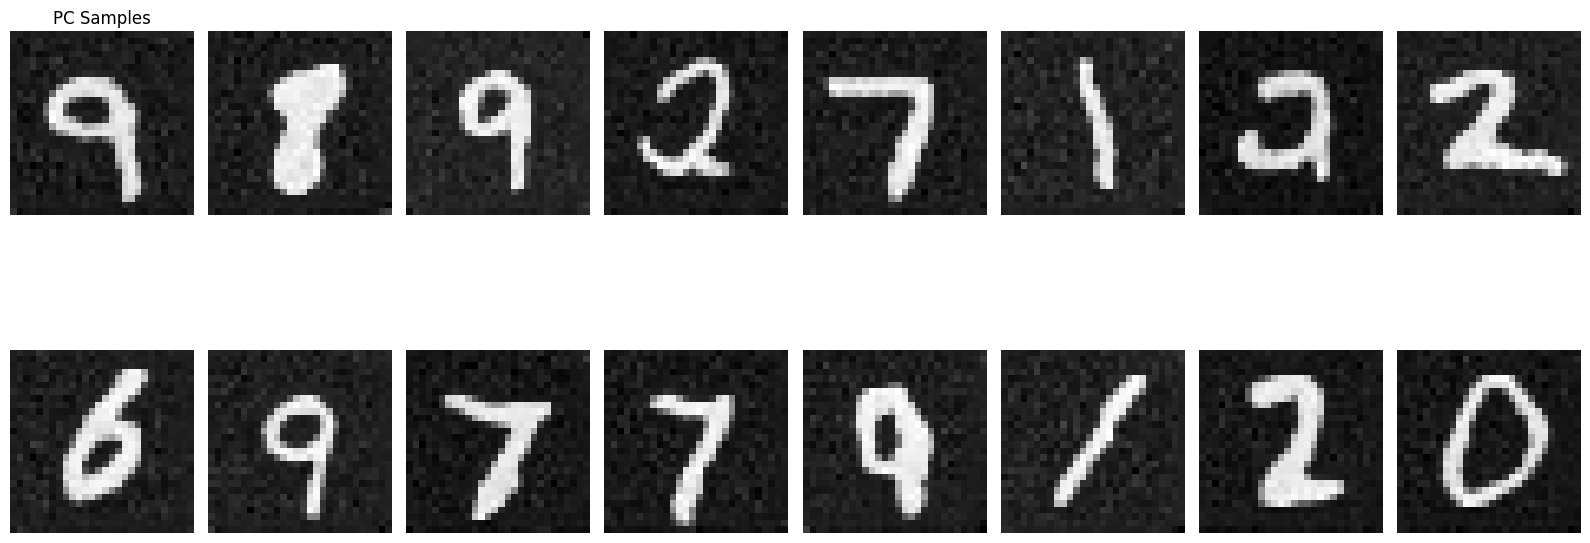

PC samples shape: torch.Size([16, 1, 28, 28])
PC samples range: [-0.173, 1.119]


In [19]:
# Generate samples and visualize results
import matplotlib.pyplot as plt

# Load the best model checkpoint (you may need to adjust the epoch number)
checkpoint_path = 'ckpt_49.pth'  # Use the last epoch or best checkpoint
score_model.load_state_dict(torch.load(checkpoint_path))
score_model.eval()


# Generate samples using PC sampler
print("Generating samples using PC sampler...")
pc_samples = pc_sampler(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                        batch_size=16, num_steps=500, device=device)

# Visualize the results
fig, axes = plt.subplots(2, 8, figsize=(16, 8))


# Display PC samples
for i in range(16):
    row = (i // 8)
    col = i % 8
    img = pc_samples[i].cpu().numpy().squeeze()
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].axis('off')
    if i == 0:
        axes[row, col].set_title('PC Samples', fontsize=12)

plt.tight_layout()
plt.show()

# Show some statistics about the generated samples
print(f"PC samples shape: {pc_samples.shape}")
print(f"PC samples range: [{pc_samples.min():.3f}, {pc_samples.max():.3f}]")

Comparison with real MNIST samples:


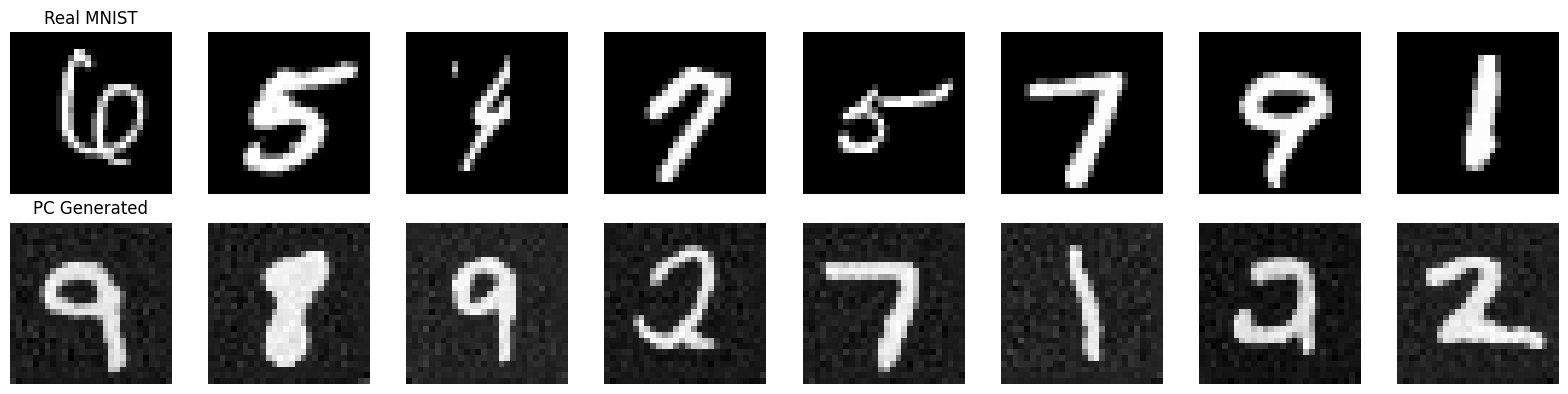

In [20]:
# Compare with real MNIST samples
def show_comparison(real_samples, generated_samples, title="Generated vs Real MNIST"):
    fig, axes = plt.subplots(2, 8, figsize=(16, 4))

    # Show real samples
    for i in range(8):
        img = real_samples[i].cpu().numpy().squeeze()
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Real MNIST', fontsize=12)

    # Show generated samples
    for i in range(8):
        img = generated_samples[i].cpu().numpy().squeeze()
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title(title, fontsize=12)

    plt.tight_layout()
    plt.show()

# Get some real MNIST samples for comparison
real_batch = next(iter(data_loader))[0][:8].to(device)

# Show comparison
print("Comparison with real MNIST samples:")
show_comparison(real_batch, pc_samples[:8], "PC Generated")